In [1]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr#;xr.set_options(display_style='text') 
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16})

import cartopy.crs as ccrs
import cartopy

import sys
p = '/global/homes/q/qnicolas'
if p not in sys.path:
    sys.path.append(p)

from tools.wrfHrTools import *
from tools.generalTools import qsat,compute_N
from orographicPrecipitation.observationsAndERA5.linearWaveModels import second_derivative_matrix,linear_w_generalized, linear_w_generalized_forced, w_to_Tprime,w_to_qprime,z_to_p_standard
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile,k_vector


SCRATCH='/global/cscratch1/sd/qnicolas/'

import scipy.linalg as spl
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

%load_ext autoreload
%autoreload 2

In [2]:
DZ = 100.
zz_full = np.arange(0.,20e3,DZ)
N0=0.01;U0=10;k0=2*np.pi/100e3;hhat0=1.
q0 = 0.02*np.exp(-zz_full/2e3)
dq0dz = np.gradient(q0,zz_full)

# Functions

In [3]:
kuangdata = loadmat("/global/u2/q/qnicolas/orographicPrecipitation/steadyLRF.mat")

Mkuang=kuangdata['M']
pres=kuangdata['pres'][:,0]
tmean=kuangdata['tmean'][:,0]
qmean=kuangdata['qmean'][:,0]
zrce = kuangdata['z'][:,0]
zT = zrce[:-2]
zQ = zrce[:14]

#Reverse positive eigenvalue
lambdas,P = spl.eig(Mkuang)
lambdas[5]*=-1
Pm1 = spl.inv(P)
Mkuang2 = np.real(np.dot(np.dot(P,np.diag(lambdas)),Pm1))

In [4]:
def QcQqfromTq(MM,zM,zforc,forcT,forcq):
    forcT_interp = np.interp(zM,zforc,forcT)[:26]
    forcq_interp = np.interp(zM,zforc,forcq)[:14]
    forcing=np.concatenate((forcT_interp,forcq_interp))
    reps = np.dot(MM,forcing)
    repQc = np.concatenate((reps[:26],[0.,0.]))
    repQq = np.concatenate((reps[26:],np.zeros(14)))
    return np.interp(zforc,zM,repQc,left=0.,right=0.),np.interp(zforc,zM,repQq,left=0.,right=0.)

In [5]:
from calc_GW_LRF import *

In [6]:
g = 9.81
Lv = 2.5e6
cp=1004.
Rd = 287.
T0=300.

In [7]:
#class SimulationCustom(Simulation):
#    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
#        super().__init__(path,center,dx,inp,out,pout,is_subset)
#        self.suffix2 = suffix2
#        #self.RAINNC  = xr.open_zarr(self.path+'wrf.SFCVARS.1h.%s.zarr'%self.suffix2).RAINNC_MMDY
#        self.T_PL_MEAN = xr.open_dataarray(self.path+'wrf.T_PL.ALLMEAN.nc')
#        self.Q_PL_MEAN = xr.open_dataarray(self.path+'wrf.Q_PL.ALLMEAN.nc')
#        sample_pout = xr.open_dataset(sorted(glob.glob(self.path+"wrfpout*"))[20])
#        Z_all = change_coords_pl(sample_pout,sample_pout.GHT_PL).sel(distance_from_mtn=slice(-2000,-5000))
#        self.Z_PL_SNAP = Z_all.where(Z_all>0).mean(['Time','south_north','distance_from_mtn'])
#        self.N_PL_MEAN = compute_N(self.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')

class SimulationCustom():
    def __init__(self,path,center,dx,suffix2,inp=False,out=False,pout=False,is_subset=False):
        self.T_PL_MEAN = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.T_PL_MEAN.nc")
        self.Q_PL_MEAN = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.Q_PL_MEAN.nc")
        self.Z_PL_SNAP = xr.open_dataarray("/global/cfs/projectdirs/m3310/qnicolas/W10S300.Z_PL_SNAP.nc")
        self.N_PL_MEAN = compute_N(self.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),100,'pressure')


W10S300   = SimulationCustom('/pscratch/sd/q/qnicolas/wrfdata/saved/channel.wrf.100x2.mountain.60lev.500m.3km/'          ,1635,3,'1970010100-1970072000',inp=True)
W10S300.N2_full = np.interp(zz_full,W10S300.Z_PL_SNAP,W10S300.N_PL_MEAN)**2
W10S300.dqdz_full = np.interp(zz_full,W10S300.Z_PL_SNAP,np.gradient(W10S300.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP))

In [8]:
W10S300.N2TEST = g/300*(np.gradient(W10S300.T_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP)+g/cp)
W10S300.N2TEST_full = np.interp(zz_full,W10S300.Z_PL_SNAP,W10S300.N2TEST)

In [16]:
def levs(wmax,n):
    x=np.linspace(-wmax**(1/n),wmax**(1/n),40)
    return np.sign(x)*np.abs(x)**n

levs1=levs2=levs(0.2,2)
wticks=[-.2,-.1,-.03,0.,.03,.1,.2]

# With uniform stratification & exponential q0(z)

In [12]:
DZ = 100.
zz_full = np.arange(0.,20e3,DZ)
N0=0.01;U0=10;k0=2*np.pi/100e3;hhat0=1.
q0 = 0.02*np.exp(-zz_full/2e3)
dq0dz = np.gradient(q0,zz_full)

Text(0.5, 1.0, 'Qc (K/day)')

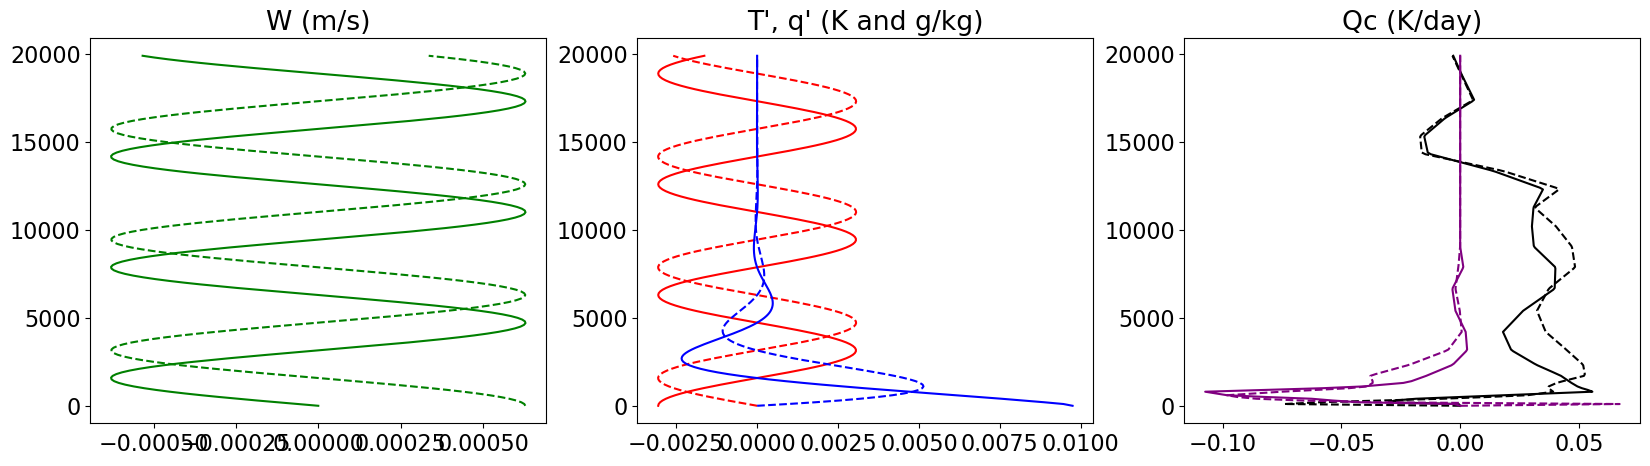

In [13]:
ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)

bprime = -ww*N0**2/(1j*k0*U0)
Tprime = bprime/g*300.
qprime = -ww*dq0dz/(1j*k0*U0)

Qc,Qq = QcQqfromTq(Mkuang2,zrce,zz_full,Tprime,qprime*1000)

_,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.real(ww),zz_full,color='g')
axs[0].plot(np.imag(ww),zz_full,color='g',linestyle='--')
axs[1].plot(np.real(Tprime),zz_full,color='r')
axs[1].plot(np.imag(Tprime),zz_full,color='r',linestyle='--')
axs[1].plot(np.real(qprime)*1e3,zz_full,color='b')
axs[1].plot(np.imag(qprime)*1e3,zz_full,color='b',linestyle='--')

axs[2].plot(np.real(Qc),zz_full,color='k',linestyle='-')
axs[2].plot(np.imag(Qc),zz_full,color='k',linestyle='--')
axs[2].plot(np.real(Qq),zz_full,color='purple',linestyle='-')
axs[2].plot(np.imag(Qq),zz_full,color='purple',linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T', q' (K and g/kg)")
axs[2].set_title('Qc (K/day)')

Text(0.5, 1.0, 'Qc (K/day)')

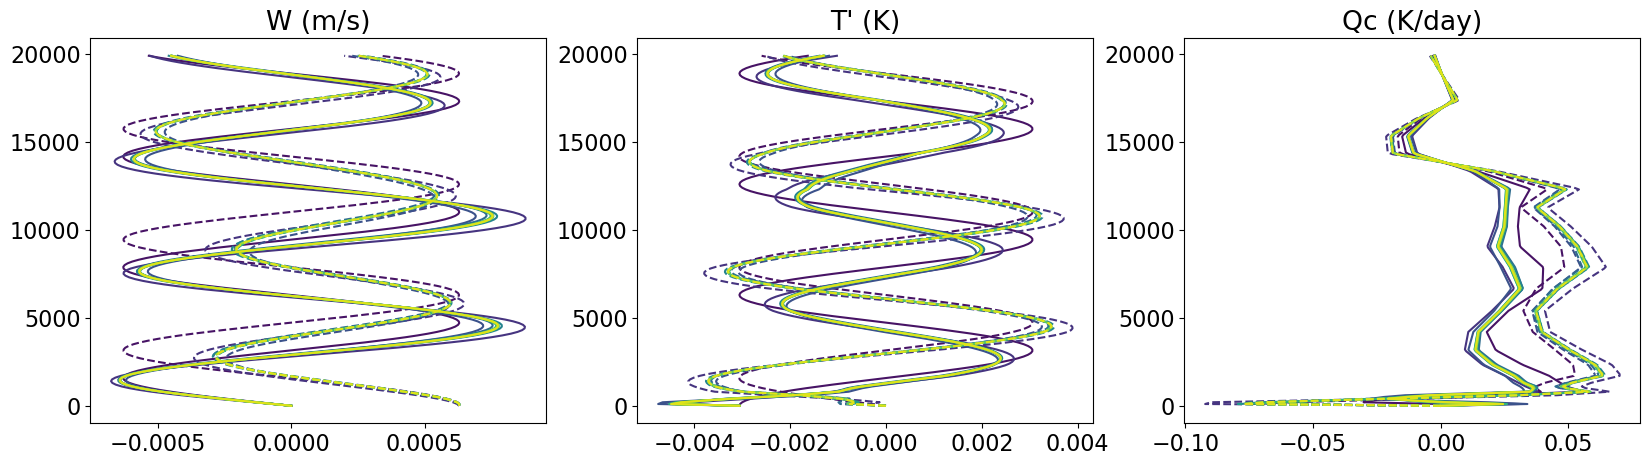

In [14]:
def iterate(niter):
    ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)
    Qb = 0.;Qq=0.
    ws=[];Ts=[];qs=[];Qcs=[];Qqs=[]
    for _ in range(niter):
        bprime = (-ww*N0**2 + Qb)/(1j*k0*U0)
        Tprime = bprime/g*300.
        qprime = (-ww*dq0dz + Qq/(1000*86400))/(1j*k0*U0)
        
        Qc,Qq = QcQqfromTq(Mkuang2,zrce,zz_full,Tprime,qprime*1000)
        Qqs.append(Qq)
        Qb = Qc*g/300./86400
        
        ws.append(ww);Ts.append(Tprime);qs.append(qprime);Qcs.append(Qc)
        ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,Qb/U0**2)
    return ws,Ts,qs,Qcs,Qqs


ws,Ts,qs,Qcs,Qqs = iterate(10)
_,axs = plt.subplots(1,3,figsize=(20,5))
N=10
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    axs[0].plot(np.real(ws[i]),zz_full,color=colors[i])
    axs[0].plot(np.imag(ws[i]),zz_full,color=colors[i],linestyle='--')
    axs[1].plot(np.real(Ts[i]),zz_full,color=colors[i])
    axs[1].plot(np.imag(Ts[i]),zz_full,color=colors[i],linestyle='--')
    axs[2].plot(np.real(Qcs[i]),zz_full,color=colors[i])
    axs[2].plot(np.imag(Qcs[i]),zz_full,color=colors[i],linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T' (K)")
axs[2].set_title('Qc (K/day)')

(-0.18, 0.18)

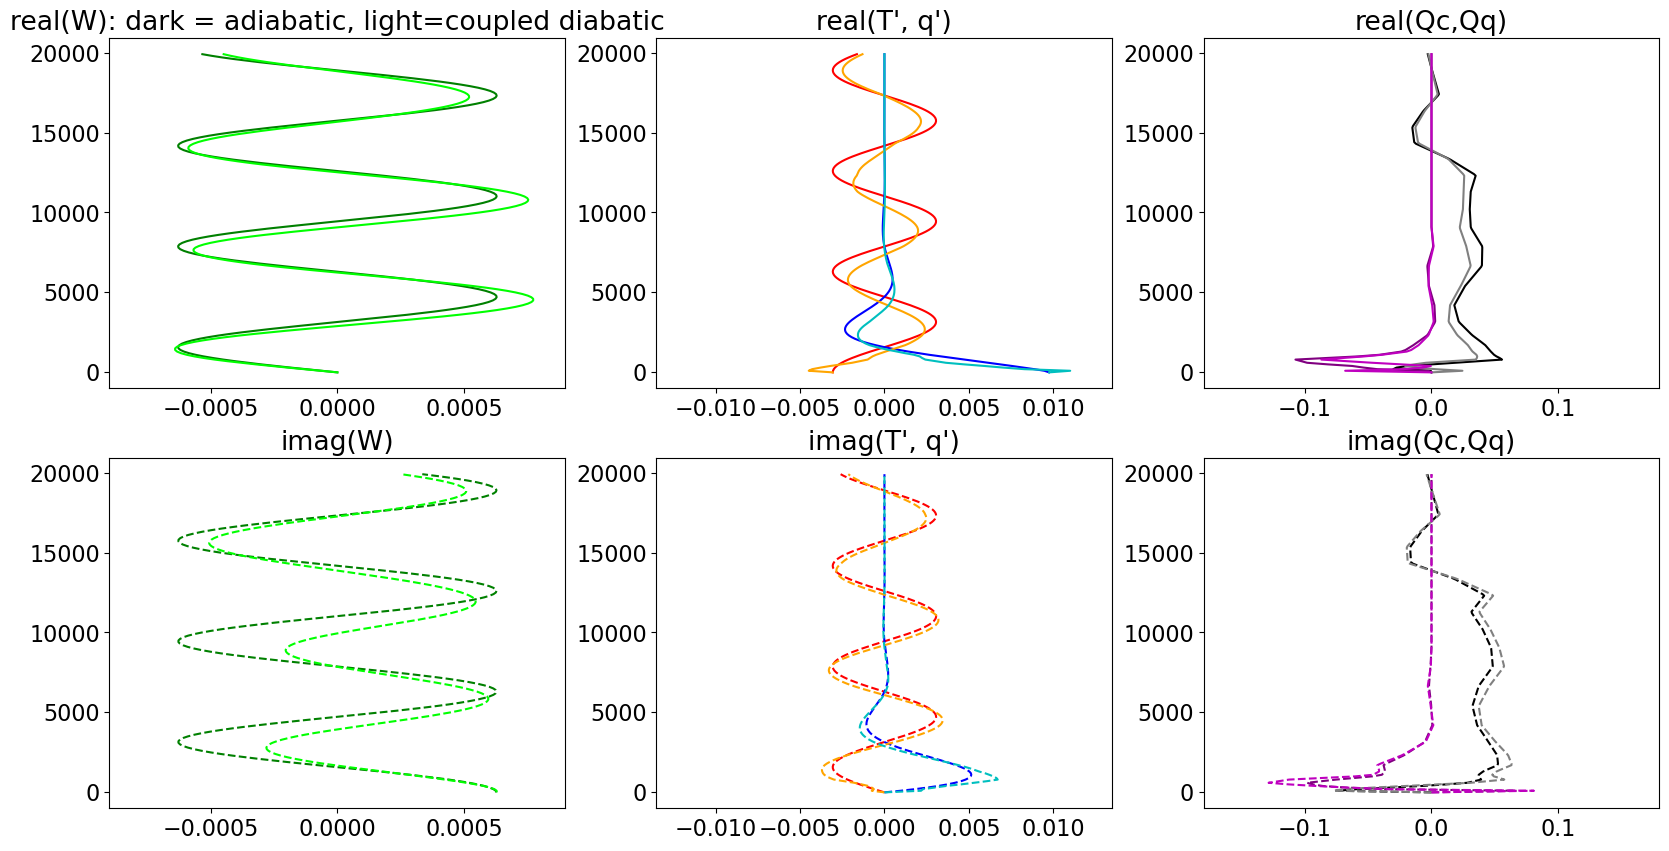

In [11]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']
for i in (0,-1):
    axs[0,0].plot(np.real(ws[i]),zz_full,color=colorsw[i])
    axs[0,1].plot(np.real(Ts[i]),zz_full,color=colorsT[i])
    axs[0,1].plot(np.real(qs[i]*1e3),zz_full,color=colorsq[i])
    axs[0,2].plot(np.real(Qcs[i]),zz_full,color=colorsQc[i])
    axs[0,2].plot(np.real(Qqs[i]),zz_full,color=colorsQq[i])
    axs[1,0].plot(np.imag(ws[i]),zz_full,color=colorsw[i],linestyle='--')
    axs[1,1].plot(np.imag(Ts[i]),zz_full,color=colorsT[i],linestyle='--')
    axs[1,1].plot(np.imag(qs[i]*1e3),zz_full,color=colorsq[i],linestyle='--')
    axs[1,2].plot(np.imag(Qcs[i]),zz_full,color=colorsQc[i],linestyle='--')
    axs[1,2].plot(np.imag(Qqs[i]),zz_full,color=colorsQq[i],linestyle='--')
    
axs[0,0].set_title('real(W): dark = adiabatic, light=coupled diabatic')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')
xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

In [12]:
wTEST,TTEST,qTEST,QcTEST,QqTEST = coupled_gw_mode(zz_full,zrce,0*zz_full+N0**2*T0/g,dq0dz,k0,hhat0,U0,Mkuang2,coupling='full')


(-0.18, 0.18)

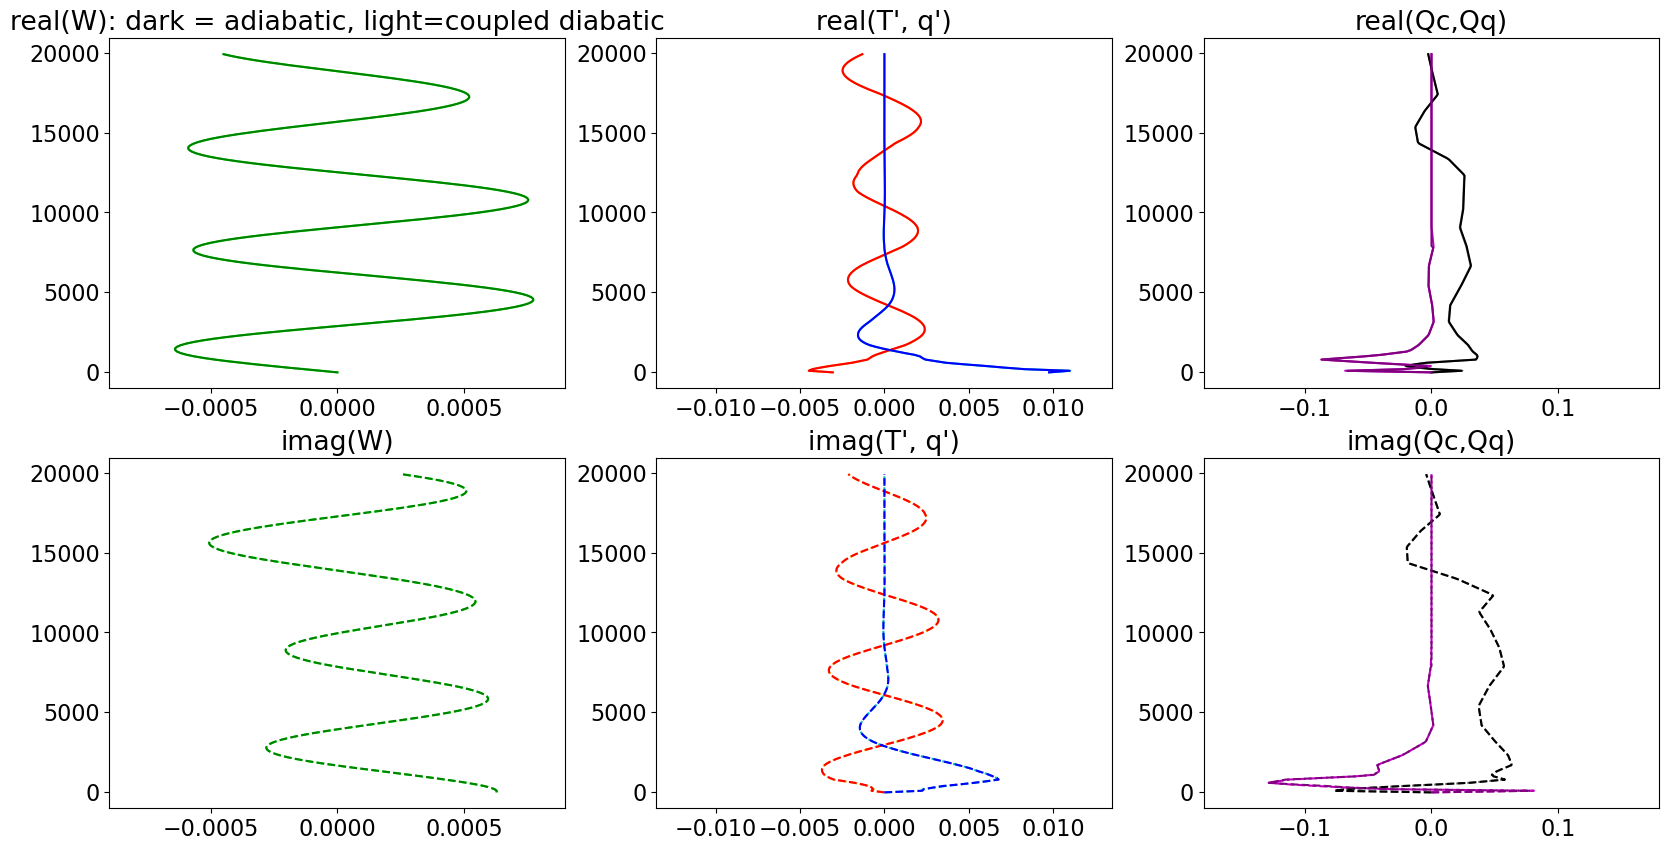

In [17]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']
for i in (-1,):
    axs[0,0].plot(np.real(ws[i]),zz_full,color=colorsw[i])
    axs[0,1].plot(np.real(Ts[i]),zz_full,color=colorsT[i])
    axs[0,1].plot(np.real(1000*qs[i]),zz_full,color=colorsq[i])
    axs[0,2].plot(np.real(Qcs[i]),zz_full,color=colorsQc[i])
    axs[0,2].plot(np.real(Qqs[i]),zz_full,color=colorsQq[i])
    axs[1,0].plot(np.imag(ws[i]),zz_full,color=colorsw[i],linestyle='--')
    axs[1,1].plot(np.imag(Ts[i]),zz_full,color=colorsT[i],linestyle='--')
    axs[1,1].plot(np.imag(1000*qs[i]),zz_full,color=colorsq[i],linestyle='--')
    axs[1,2].plot(np.imag(Qcs[i]),zz_full,color=colorsQc[i],linestyle='--')
    axs[1,2].plot(np.imag(Qqs[i]),zz_full,color=colorsQq[i],linestyle='--')
    
i=0
axs[0,0].plot(np.real(wTEST),zz_full,color=colorsw[i])
axs[0,1].plot(np.real(TTEST),zz_full,color=colorsT[i])
axs[0,1].plot(np.real(qTEST),zz_full,color=colorsq[i])
axs[0,2].plot(np.real(86400*QcTEST),zz_full,color=colorsQc[i])
axs[0,2].plot(np.real(86400*QqTEST),zz_full,color=colorsQq[i])
axs[1,0].plot(np.imag(wTEST),zz_full,color=colorsw[i],linestyle='--')
axs[1,1].plot(np.imag(TTEST),zz_full,color=colorsT[i],linestyle='--')
axs[1,1].plot(np.imag(qTEST),zz_full,color=colorsq[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QcTEST),zz_full,color=colorsQc[i],linestyle='--')
axs[1,2].plot(np.imag(86400*QqTEST),zz_full,color=colorsQq[i],linestyle='--')

    
axs[0,0].set_title('real(W): dark = adiabatic, light=coupled diabatic')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')
xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

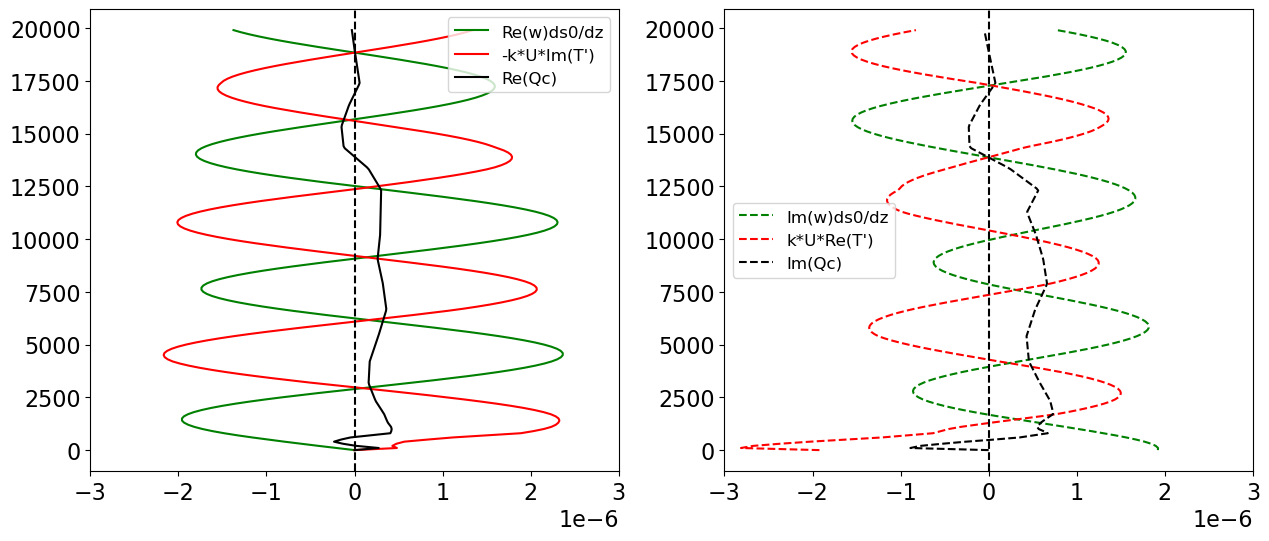

In [18]:
_,axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(np.real(wTEST)*N0**2/g*T0,zz_full,color='g'        ,label='Re(w)ds0/dz')
axs[0].plot(-k0*U0*np.imag(TTEST)    ,zz_full,color='r'        ,label="-k*U*Im(T')")
axs[0].plot(np.real(QcTEST)    ,zz_full,color=colorsQc[i],label="Re(Qc)"     )

axs[1].plot(np.imag(wTEST)*N0**2/g*T0,zz_full,color='g'        ,linestyle='--',label='Im(w)ds0/dz')
axs[1].plot(k0*U0*np.real(TTEST)     ,zz_full,color='r'        ,linestyle='--',label="k*U*Re(T')")
axs[1].plot(np.imag(QcTEST)    ,zz_full,color=colorsQc[i],linestyle='--',label="Im(Qc)"     )

axs[0].axvline(0.,color='k',linestyle='--')
axs[1].axvline(0.,color='k',linestyle='--')

xlim=3e-6
axs[0].set_xlim(-xlim,xlim);axs[0].legend(fontsize=12)
axs[1].set_xlim(-xlim,xlim);axs[1].legend(fontsize=12)

# with ZBP stratification & exponential q0(z)

In [10]:
from ZBP import *
EPSILON = 0.6e-3#1e-6#
zz = np.arange(1000,20e3,DZ)

Ref = ZBP(zz,zz*0,epsilon=EPSILON); Ref.integrate(); Ref.calc_precip(); Ref.calc_Q()
Ref.N2 = (g/300. *(np.gradient(Ref.TT,Ref.zz)+g/cp))

idxs = zz_full>=zz[0]
N2_full = np.interp(zz_full,np.concatenate(([0.],Ref.zz)),np.concatenate(([0.],Ref.N2)))
N2_custom = np.maximum(N2_full,0.4e-4)

Text(0.5, 1.0, 'Qc (K/day)')

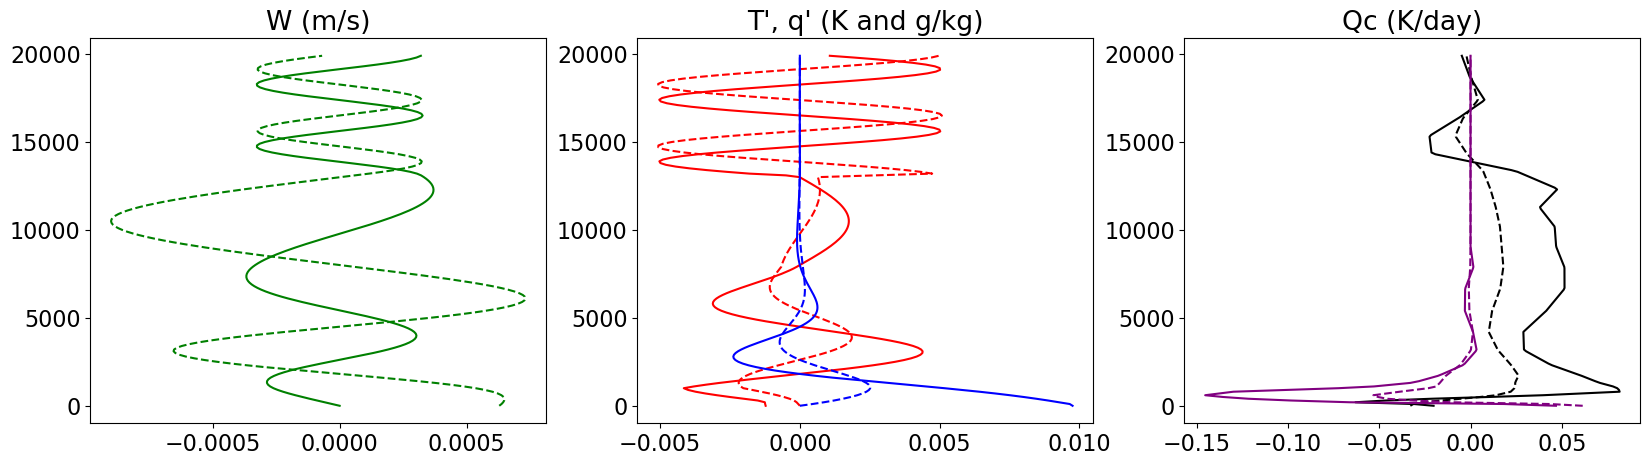

In [11]:
ww = gw_mode_forced(zz_full,N2_custom/U0**2,k0,hhat0,U0,0*zz_full)

bprime = -ww*N2_custom/(1j*k0*U0)
Tprime = bprime/g*300.
qprime = -ww*dq0dz/(1j*k0*U0)

Qc,Qq = QcQqfromTq(M,zrce,zz_full,Tprime,qprime*1000)

_,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.real(ww),zz_full,color='g')
axs[0].plot(np.imag(ww),zz_full,color='g',linestyle='--')
axs[1].plot(np.real(Tprime),zz_full,color='r')
axs[1].plot(np.imag(Tprime),zz_full,color='r',linestyle='--')
axs[1].plot(np.real(qprime)*1e3,zz_full,color='b')
axs[1].plot(np.imag(qprime)*1e3,zz_full,color='b',linestyle='--')

axs[2].plot(np.real(Qc),zz_full,color='k',linestyle='-')
axs[2].plot(np.imag(Qc),zz_full,color='k',linestyle='--')
axs[2].plot(np.real(Qq),zz_full,color='purple',linestyle='-')
axs[2].plot(np.imag(Qq),zz_full,color='purple',linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T', q' (K and g/kg)")
axs[2].set_title('Qc (K/day)')

Text(0.5, 1.0, 'Qc (K/day)')

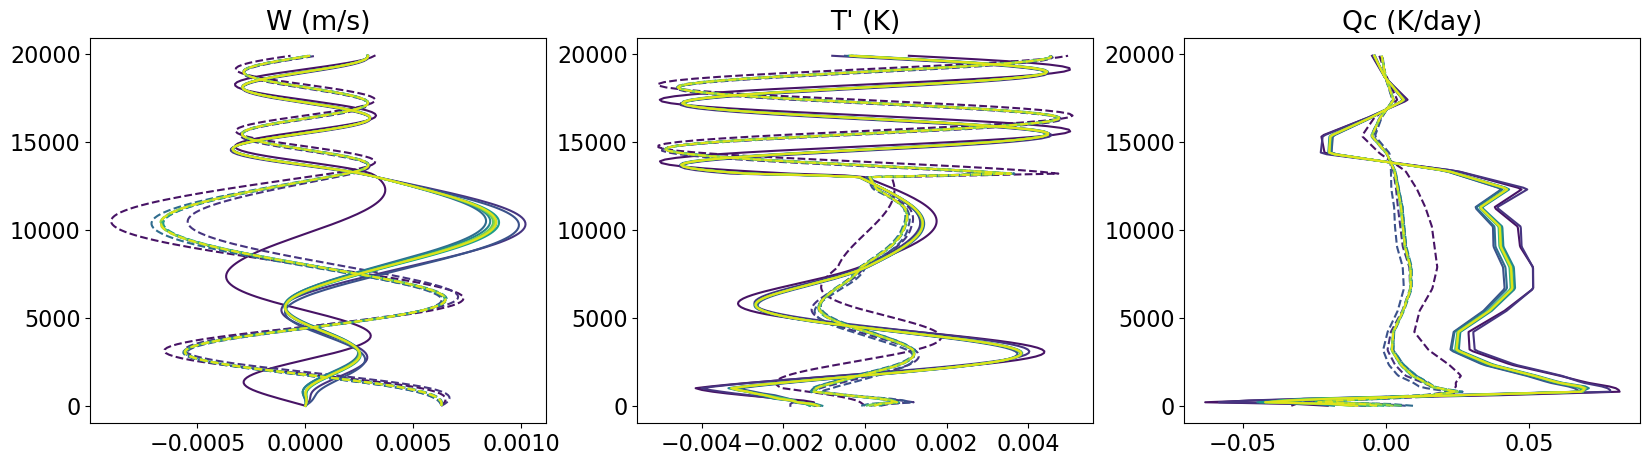

In [12]:
def iterate(niter):
    ww = gw_mode_forced(zz_full,N2_custom/U0**2,k0,hhat0,U0,0*zz_full)
    Qb = 0.;Qq=0.
    ws=[];Ts=[];qs=[];Qcs=[];Qqs=[]
    for _ in range(niter):
        bprime = (-ww*N2_custom + Qb)/(1j*k0*U0)
        Tprime = bprime/g*300.
        qprime = (-ww*dq0dz + Qq/(1000*86400))/(1j*k0*U0)
        
        Qc,Qq = QcQqfromTq(Mkuang,zrce,zz_full,Tprime,qprime*1000)
        Qqs.append(Qq)
        Qb = Qc*g/300./86400
        
        ws.append(ww);Ts.append(Tprime);qs.append(qprime);Qcs.append(Qc)
        ww = gw_mode_forced(zz_full,N2_custom/U0**2,k0,hhat0,U0,Qb/U0**2)
    return ws,Ts,qs,Qcs,Qqs


ws,Ts,qs,Qcs,Qqs = iterate(10)
_,axs = plt.subplots(1,3,figsize=(20,5))
N=10
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    axs[0].plot(np.real(ws[i]),zz_full,color=colors[i])
    axs[0].plot(np.imag(ws[i]),zz_full,color=colors[i],linestyle='--')
    axs[1].plot(np.real(Ts[i]),zz_full,color=colors[i])
    axs[1].plot(np.imag(Ts[i]),zz_full,color=colors[i],linestyle='--')
    axs[2].plot(np.real(Qcs[i]),zz_full,color=colors[i])
    axs[2].plot(np.imag(Qcs[i]),zz_full,color=colors[i],linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T' (K)")
axs[2].set_title('Qc (K/day)')

(-0.18, 0.18)

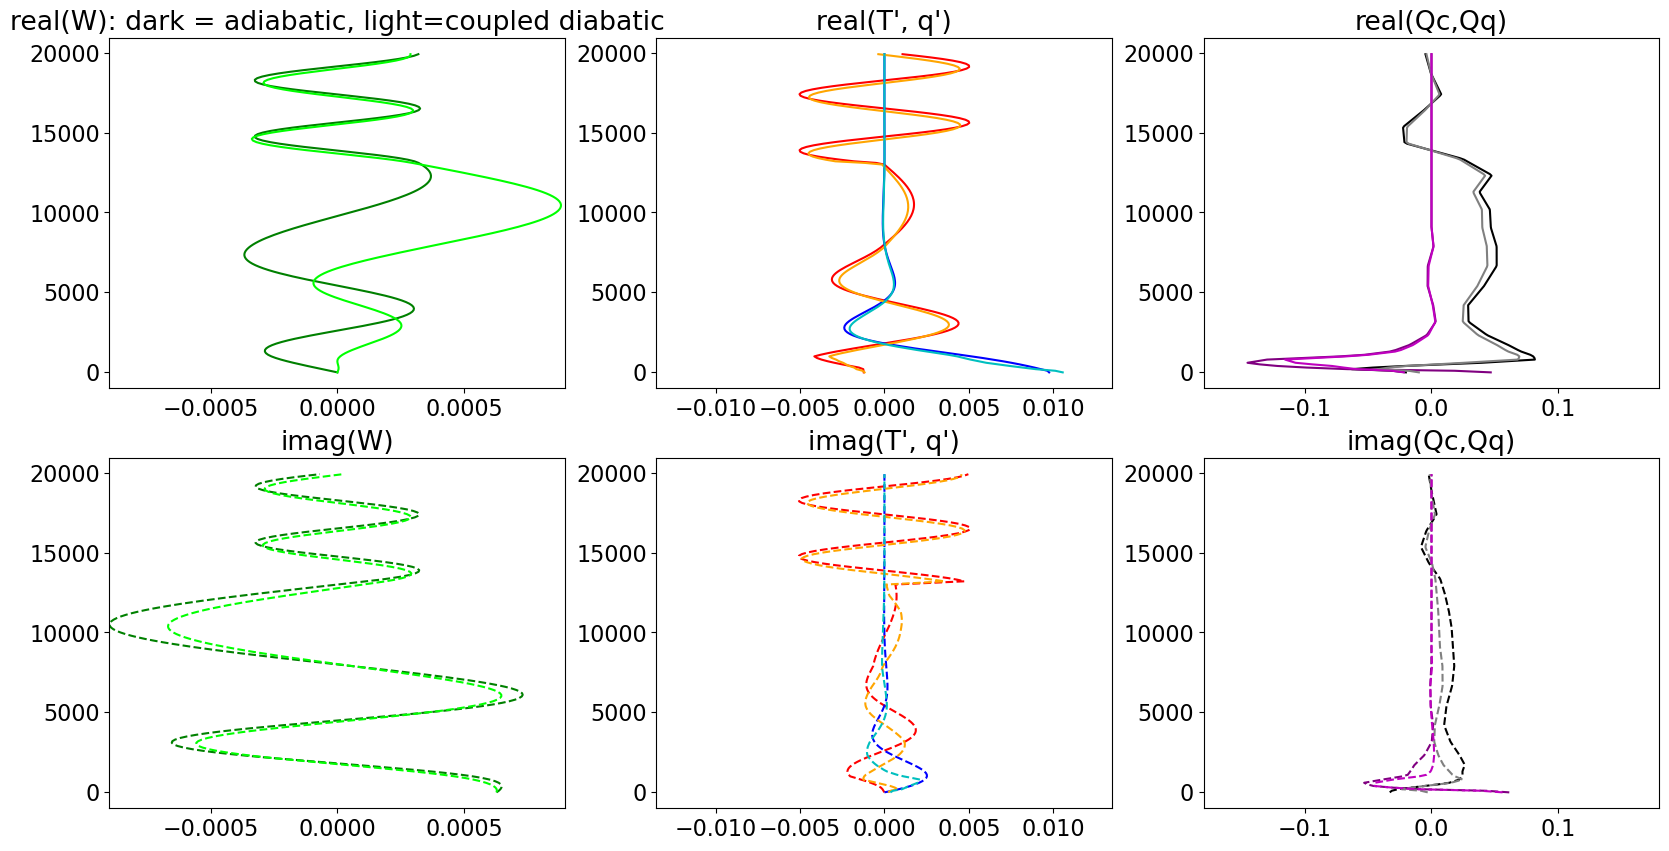

In [13]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']
for i in (0,-1):
    axs[0,0].plot(np.real(ws[i]),zz_full,color=colorsw[i])
    axs[0,1].plot(np.real(Ts[i]),zz_full,color=colorsT[i])
    axs[0,1].plot(np.real(qs[i]*1e3),zz_full,color=colorsq[i])
    axs[0,2].plot(np.real(Qcs[i]),zz_full,color=colorsQc[i])
    axs[0,2].plot(np.real(Qqs[i]),zz_full,color=colorsQq[i])
    axs[1,0].plot(np.imag(ws[i]),zz_full,color=colorsw[i],linestyle='--')
    axs[1,1].plot(np.imag(Ts[i]),zz_full,color=colorsT[i],linestyle='--')
    axs[1,1].plot(np.imag(qs[i]*1e3),zz_full,color=colorsq[i],linestyle='--')
    axs[1,2].plot(np.imag(Qcs[i]),zz_full,color=colorsQc[i],linestyle='--')
    axs[1,2].plot(np.imag(Qqs[i]),zz_full,color=colorsQq[i],linestyle='--')
    
axs[0,0].set_title('real(W): dark = adiabatic, light=coupled diabatic')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')

xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

# With WRF stratification and moisture stratification

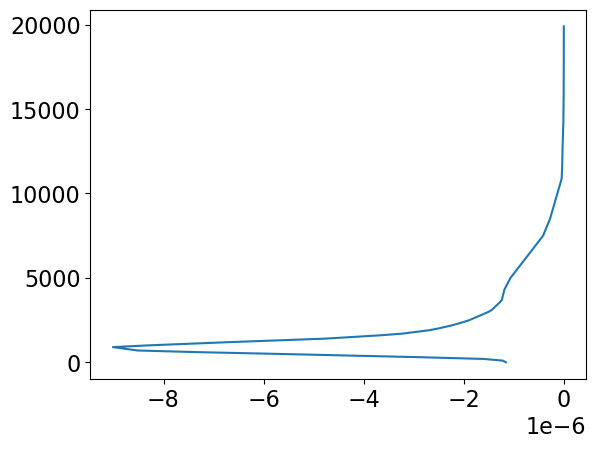

In [10]:
plt.plot(W10S300.dqdz_full,zz_full)

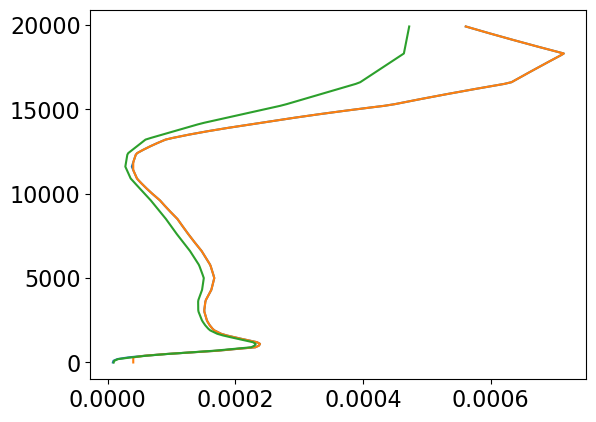

In [17]:
plt.plot(W10S300.N2_full,zz_full)
plt.plot(np.maximum(W10S300.N2_full,0.4e-4),zz_full)
plt.plot(W10S300.N2TEST_full,zz_full)


Text(0.5, 1.0, 'Qc (K/day)')

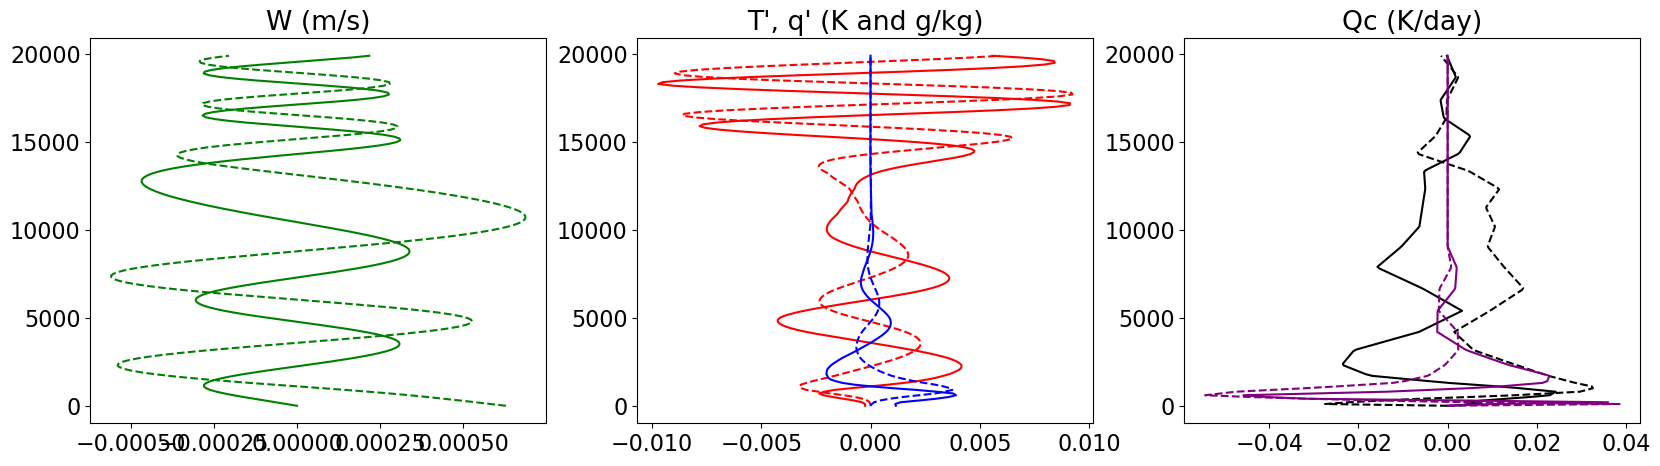

In [42]:
ww = gw_mode_forced(zz_full,W10S300.N2_full/U0**2,k0,hhat0,U0,0*zz_full)

bprime = -ww*W10S300.N2_full/(1j*k0*U0)
Tprime = bprime/g*300.
qprime = -ww*W10S300.dqdz_full/(1j*k0*U0)

Qc,Qq = QcQqfromTq(Mkuang,zrce,zz_full,Tprime,qprime*1000)

_,axs = plt.subplots(1,3,figsize=(20,5))
axs[0].plot(np.real(ww),zz_full,color='g')
axs[0].plot(np.imag(ww),zz_full,color='g',linestyle='--')
axs[1].plot(np.real(Tprime),zz_full,color='r')
axs[1].plot(np.imag(Tprime),zz_full,color='r',linestyle='--')
axs[1].plot(np.real(qprime)*1e3,zz_full,color='b')
axs[1].plot(np.imag(qprime)*1e3,zz_full,color='b',linestyle='--')

axs[2].plot(np.real(Qc),zz_full,color='k',linestyle='-')
axs[2].plot(np.imag(Qc),zz_full,color='k',linestyle='--')
axs[2].plot(np.real(Qq),zz_full,color='purple',linestyle='-')
axs[2].plot(np.imag(Qq),zz_full,color='purple',linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T', q' (K and g/kg)")
axs[2].set_title('Qc (K/day)')

Text(0.5, 1.0, 'Qc (K/day)')

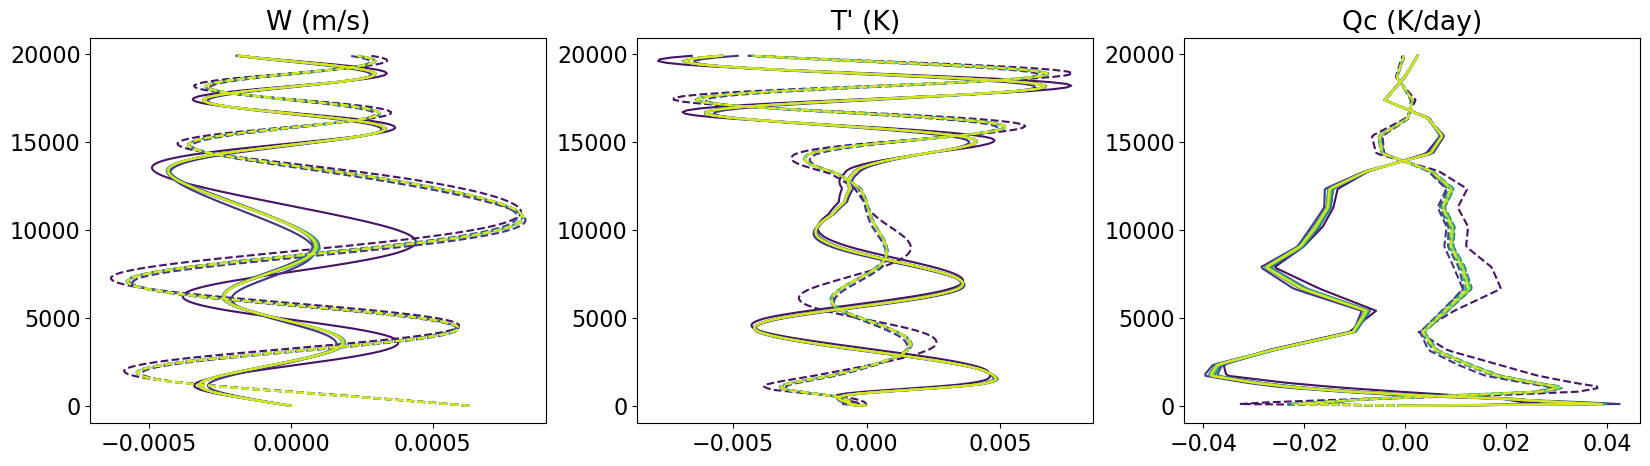

In [43]:
def iterate(niter):
    ww = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k0,hhat0,U0,0*zz_full)
    Qb = 0.;Qq=0.
    ws=[];Ts=[];qs=[];Qcs=[];Qqs=[]
    for _ in range(niter):
        bprime = (-ww*W10S300.N2TEST_full + Qb)/(1j*k0*U0)
        Tprime = bprime/g*300.
        qprime = (-ww*W10S300.dqdz_full + Qq/(1000*86400))/(1j*k0*U0)
        
        Qc,Qq = QcQqfromTq(Mkuang,zrce,zz_full,Tprime,qprime*1000)
        Qqs.append(Qq)
        Qb = Qc*g/300./86400
        
        ws.append(ww);Ts.append(Tprime);qs.append(qprime);Qcs.append(Qc)
        ww = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k0,hhat0,U0,Qb/U0**2)
    return ws,Ts,qs,Qcs,Qqs


ws,Ts,qs,Qcs,Qqs = iterate(10)
_,axs = plt.subplots(1,3,figsize=(20,5))
N=10
colors = plt.cm.viridis(np.linspace(0.05,0.95,N))
for i in range(N):
    axs[0].plot(np.real(ws[i]),zz_full,color=colors[i])
    axs[0].plot(np.imag(ws[i]),zz_full,color=colors[i],linestyle='--')
    axs[1].plot(np.real(Ts[i]),zz_full,color=colors[i])
    axs[1].plot(np.imag(Ts[i]),zz_full,color=colors[i],linestyle='--')
    axs[2].plot(np.real(Qcs[i]),zz_full,color=colors[i])
    axs[2].plot(np.imag(Qcs[i]),zz_full,color=colors[i],linestyle='--')
axs[0].set_title('W (m/s)')
axs[1].set_title("T' (K)")
axs[2].set_title('Qc (K/day)')

(-0.18, 0.18)

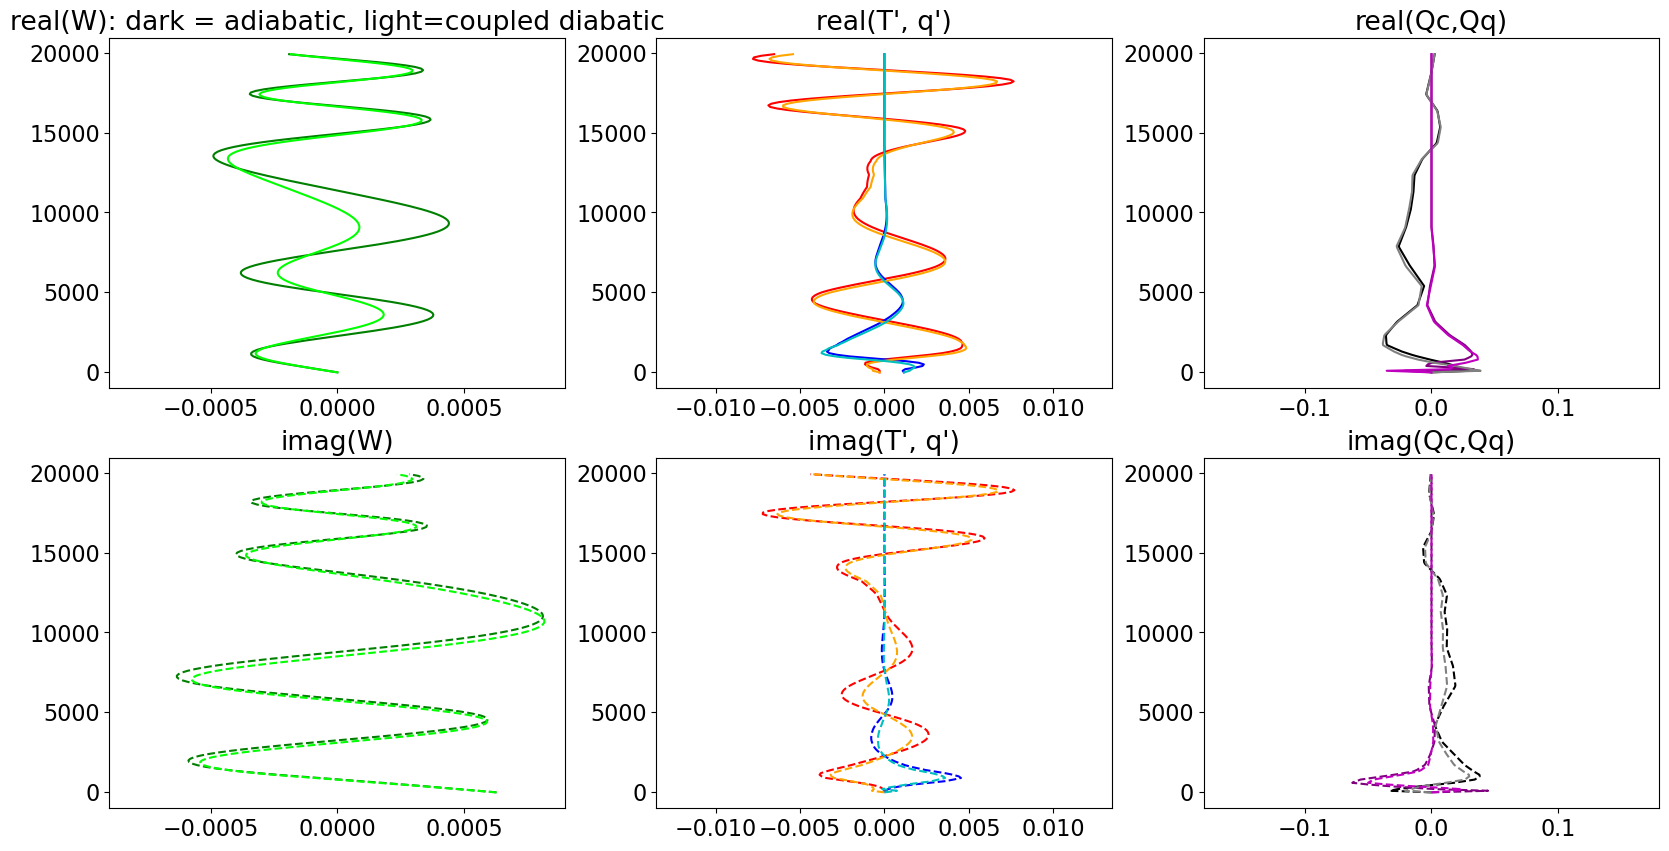

In [44]:
_,axs = plt.subplots(2,3,figsize=(20,10))
colorsw = ['g','lime']
colorsT = ['r','orange']
colorsq = ['b','c']
colorsQc = ['k','gray']
colorsQq = ['purple','m']
for i in (0,-1):
    axs[0,0].plot(np.real(ws[i]),zz_full,color=colorsw[i])
    axs[0,1].plot(np.real(Ts[i]),zz_full,color=colorsT[i])
    axs[0,1].plot(np.real(qs[i]*1e3),zz_full,color=colorsq[i])
    axs[0,2].plot(np.real(Qcs[i]),zz_full,color=colorsQc[i])
    axs[0,2].plot(np.real(Qqs[i]),zz_full,color=colorsQq[i])
    axs[1,0].plot(np.imag(ws[i]),zz_full,color=colorsw[i],linestyle='--')
    axs[1,1].plot(np.imag(Ts[i]),zz_full,color=colorsT[i],linestyle='--')
    axs[1,1].plot(np.imag(qs[i]*1e3),zz_full,color=colorsq[i],linestyle='--')
    axs[1,2].plot(np.imag(Qcs[i]),zz_full,color=colorsQc[i],linestyle='--')
    axs[1,2].plot(np.imag(Qqs[i]),zz_full,color=colorsQq[i],linestyle='--')
    
axs[0,0].set_title('real(W): dark = adiabatic, light=coupled diabatic')
axs[0,1].set_title("real(T', q')")
axs[0,2].set_title('real(Qc,Qq)')
axs[1,0].set_title('imag(W)')
axs[1,1].set_title("imag(T', q')")
axs[1,2].set_title('imag(Qc,Qq)')

xlim =9e-4 ;axs[0,0].set_xlim(-xlim,xlim)  ;axs[1,0].set_xlim(-xlim,xlim)
xlim2=15*xlim ;axs[0,1].set_xlim(-xlim2,xlim2);axs[1,1].set_xlim(-xlim2,xlim2)
xlim3=200*xlim;axs[0,2].set_xlim(-xlim3,xlim3);axs[1,2].set_xlim(-xlim3,xlim3)

# Summing several modes

## Finding the smallest number of necessary modes

In [33]:
def calc_w_general(Sim,stride=1,start=1000):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    #thresh = 3e-5
    #hx = np.fft.ifft(np.fft.fft(hx)*(np.abs(kk)<thresh))*1.2
    #hx = np.fft.ifft(np.fft.fft(hx)*(np.abs(kk)==kk[30]))*70
    
    z=np.arange(0,20e3,DZ)
    p = interp1d(Sim.Z_PL_SNAP,Sim.Z_PL_SNAP.pressure,kind='linear',fill_value='extrapolate')(z)
    N = interp1d(Sim.Z_PL_SNAP,Sim.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
    U = 10.*z**0
    w_general = linear_w_generalized(xx,hx,z,U,N)
    return w_general.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})

In [34]:
w_300_general = calc_w_general(W10S300)
w_300_general2 = calc_w_general(W10S300,stride=6)
w_300_general3 = calc_w_general(W10S300,stride=6,start=34)

0 500 1000 1500 2000 0 0 

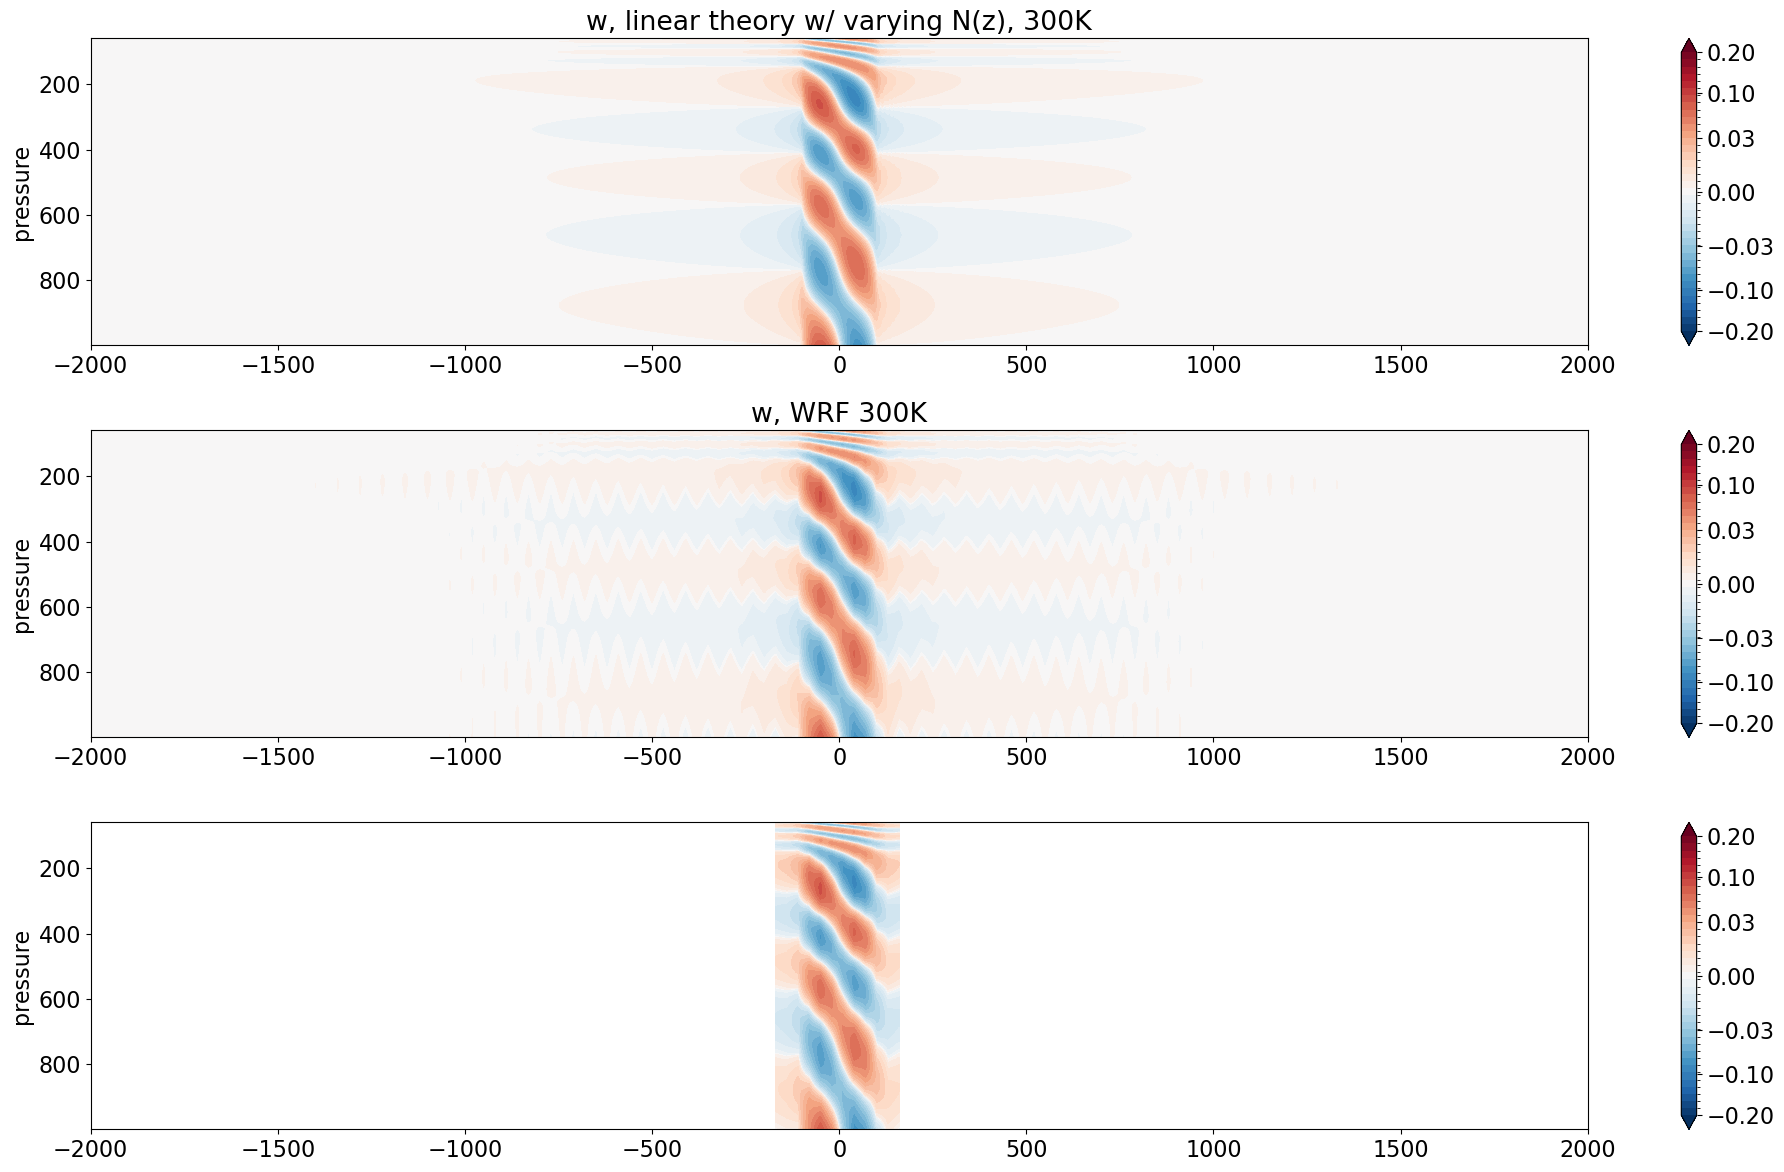

In [19]:
fig,axs = plt.subplots(3,1,figsize=(20,12))
w_300_general.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_300_general2.plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
w_300_general3.plot.contourf(ax=axs[2],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.set_xlabel("")
axs[0].set_title('w, linear theory w/ varying N(z), 300K')
axs[1].set_title('w, WRF 300K')
fig.tight_layout()

In [45]:
T_300_general  = w_to_Tprime(w_300_general ,U0,np.sqrt(W10S300.N2_full))
T_300_general2 = w_to_Tprime(w_300_general2,U0,np.sqrt(W10S300.N2_full))
T_300_general3 = w_to_Tprime(w_300_general3,U0,np.sqrt(W10S300.N2_full))
q_300_general  = w_to_qprime(w_300_general ,U0,W10S300.dqdz_full)
q_300_general2 = w_to_qprime(w_300_general2,U0,W10S300.dqdz_full)
q_300_general3 = w_to_qprime(w_300_general3,U0,W10S300.dqdz_full)

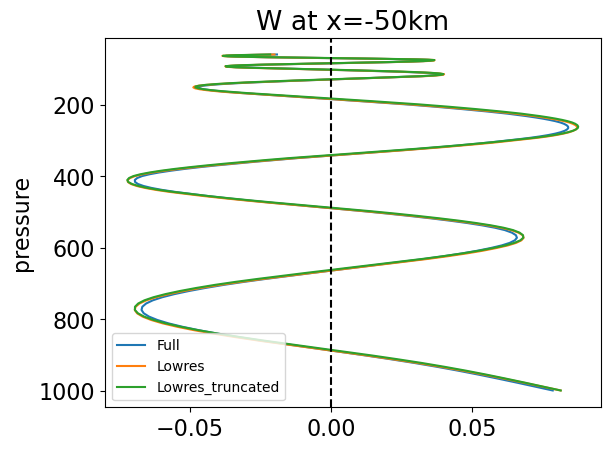

In [68]:
w_300_general .sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Full')
w_300_general2.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres')
w_300_general3.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres_truncated')

plt.axvline(0.,color='k',linestyle='--')
plt.title('W at x=-50km')
plt.legend(fontsize=10)

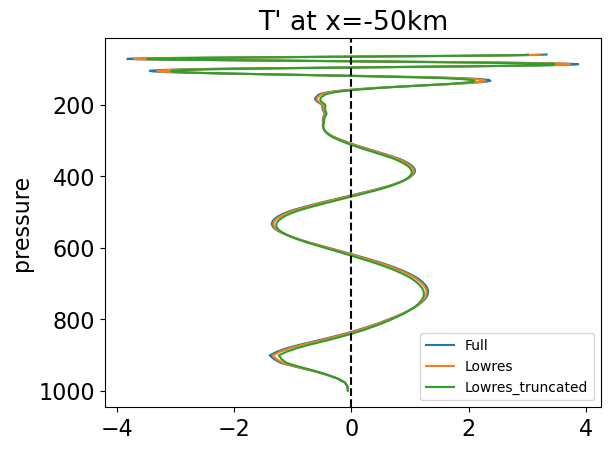

In [143]:
T_300_general .sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Full')
T_300_general2.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres')
T_300_general3.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres_truncated')

plt.axvline(0.,color='k',linestyle='--')
plt.title("T' at x=-50km")
plt.legend(fontsize=10)

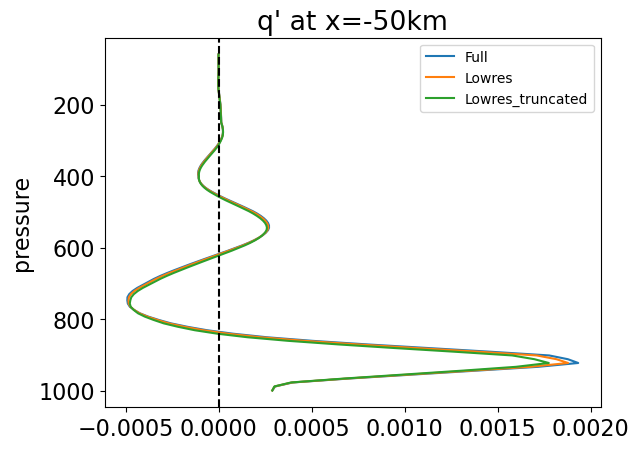

In [147]:
q_300_general .sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Full')
q_300_general2.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres')
q_300_general3.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Lowres_truncated')

plt.axvline(0.,color='k',linestyle='--')
plt.title("q' at x=-50km")
plt.legend(fontsize=10)

## Summing

In [117]:
#def onemode(k0,hhat0,U0=10.,niter=4):
#    ww = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k0,hhat0,U0,0*zz_full)
#    Qb = 0.;Qq=0.
#    #ws=[];Ts=[];qs=[];Qcs=[];Qqs=[]
#    for _ in range(niter):
#        bprime = (-ww*W10S300.N2TEST_full + Qb)/(1j*k0*U0)
#        Tprime = bprime/g*300.
#        qprime = (-ww*W10S300.dqdz_full + Qq/(1000*86400))/(1j*k0*U0)
#        
#        Qc,Qq = QcQqfromTq(Mkuang,zrce,zz_full,Tprime,qprime*1000)
#        Qb = Qc*g/300./86400
#        
#        #ws.append(ww);Ts.append(Tprime);qs.append(qprime);Qcs.append(Qc);Qqs.append(Qq)
#        ww = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k0,hhat0,U0,Qb/U0**2)
#    #return ws,Ts,qs,Qcs,Qqs
#    return ww,Tprime,qprime,Qc,Qq

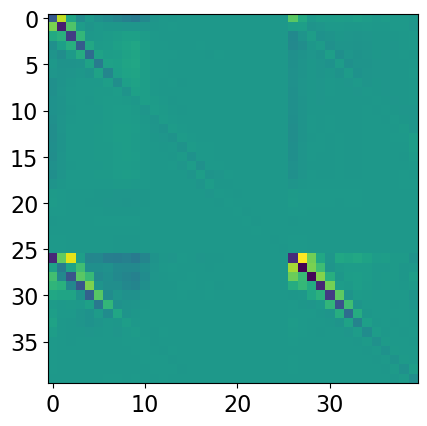

In [30]:
plt.imshow(Mkuang)

In [118]:
def sum_sol(stride=6,start=34,coupling='full',MM=Mkuang2):#niter_per_mode=4
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    kk=k_vector(len(xx),xx[1]-xx[0]); kk[0] = 1e5 # just some dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    w_hat  =np.zeros((len(kk),len(zz_full)))*1j
    T_hat  =np.zeros((len(kk),len(zz_full)))*1j
    q_hat  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hat =np.zeros((len(kk),len(zz_full)))*1j
    Qq_hat =np.zeros((len(kk),len(zz_full)))*1j
    
    itp1_matrix = np.block([[make_interp_matrix(zz_full,zrce[:26]),np.zeros((26,len(zz_full)))],[np.zeros((14,len(zz_full))),make_interp_matrix(zz_full,zrce[:14])]])
    itp2_matrix = make_interp_matrix(zrce[:26],zz_full)
    itp3_matrix = np.block([[itp2_matrix,np.zeros((len(zz_full),14))],[np.zeros((len(zz_full),26)),make_interp_matrix(zrce[:14],zz_full)]])
    
    for i,k in enumerate(kk):
        if i%10==0:
            print(i,end=' ')
        ww,Tprime,qprime,Qc,Qq = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,k,h_hat[i],U0,MM,coupling=coupling,itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        w_hat [i] = ww
        T_hat [i] = Tprime
        q_hat [i] = qprime 
        Qc_hat[i] = Qc 
        Qq_hat[i] = Qq 
        
    ww     = xr.DataArray(np.real(np.fft.ifft(w_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Tprime = xr.DataArray(np.real(np.fft.ifft(T_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    qprime = xr.DataArray(np.real(np.fft.ifft(q_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qc     = xr.DataArray(np.real(np.fft.ifft(Qc_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qq     = xr.DataArray(np.real(np.fft.ifft(Qq_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    return ww    ,Tprime,qprime,Qc    ,Qq   



 

In [41]:
%time ww__,Tprime__,qprime__,Qc__,Qq__ = sum_sol(stride=4,start=502,coupling='noq')


0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 CPU times: user 36.7 s, sys: 5.67 s, total: 42.4 s
Wall time: 21.4 s


In [42]:
ww__.distance_from_mtn[120:140]

<xarray.DataArray 'distance_from_mtn' (distance_from_mtn: 20)>
array([-110.,  -90.,  -70.,  -50.,  -30.,  -10.,   10.,   30.,   50.,   70.,
         90.,  110.,  130.,  150.,  170.,  190.,  210.,  230.,  250.,  270.])
Coordinates:
  * distance_from_mtn  (distance_from_mtn) float64 -110.0 -90.0 ... 250.0 270.0

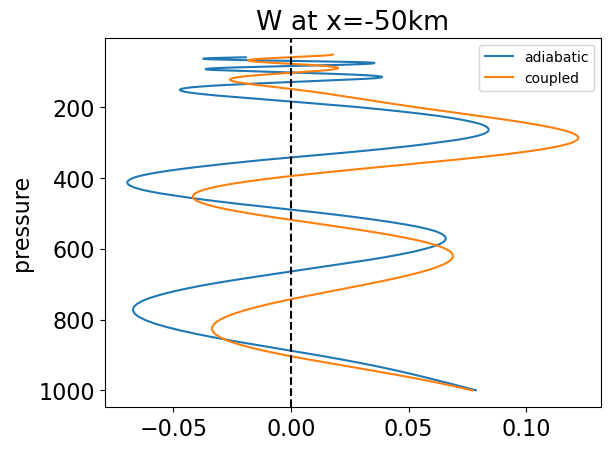

In [43]:
w_300_general .sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='adiabatic')
ww__.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='coupled')

plt.axvline(0.,color='k',linestyle='--')
plt.title('W at x=-50km')
plt.legend(fontsize=10)

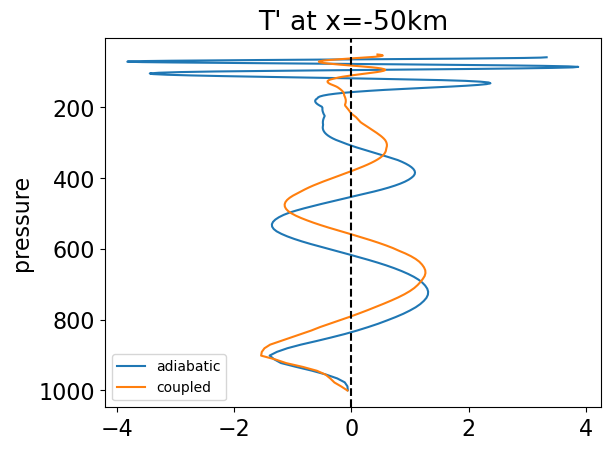

In [46]:
T_300_general.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='adiabatic')
Tprime__.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='coupled')

plt.axvline(0.,color='k',linestyle='--')
plt.title("T' at x=-50km")
plt.legend(fontsize=10)

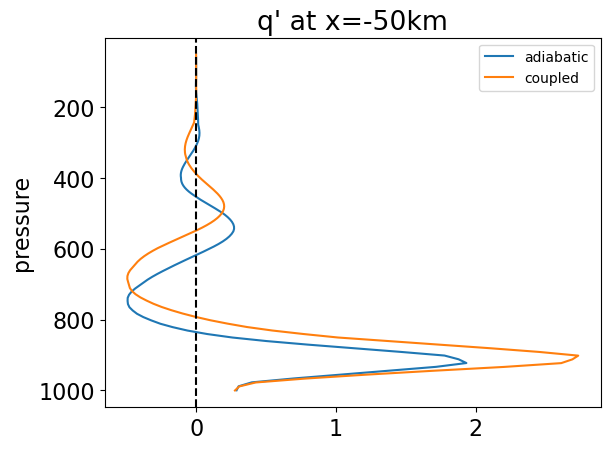

In [48]:
(q_300_general*1e3).sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='adiabatic')
qprime__.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='coupled')

plt.axvline(0.,color='k',linestyle='--')
plt.title("q' at x=-50km")
plt.legend(fontsize=10)

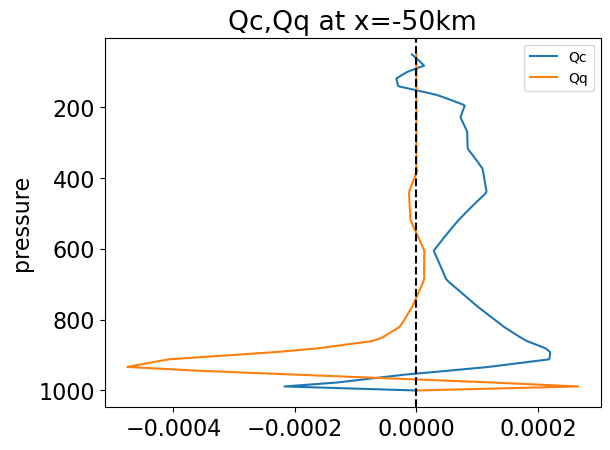

In [49]:
Qc__.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Qc')
Qq__.sel(distance_from_mtn=-50).plot(y='pressure',yincrease=False,label='Qq')

plt.axvline(0.,color='k',linestyle='--')
plt.title("Qc,Qq at x=-50km")
plt.legend(fontsize=10)

Text(0, 0.5, 'mm/day')

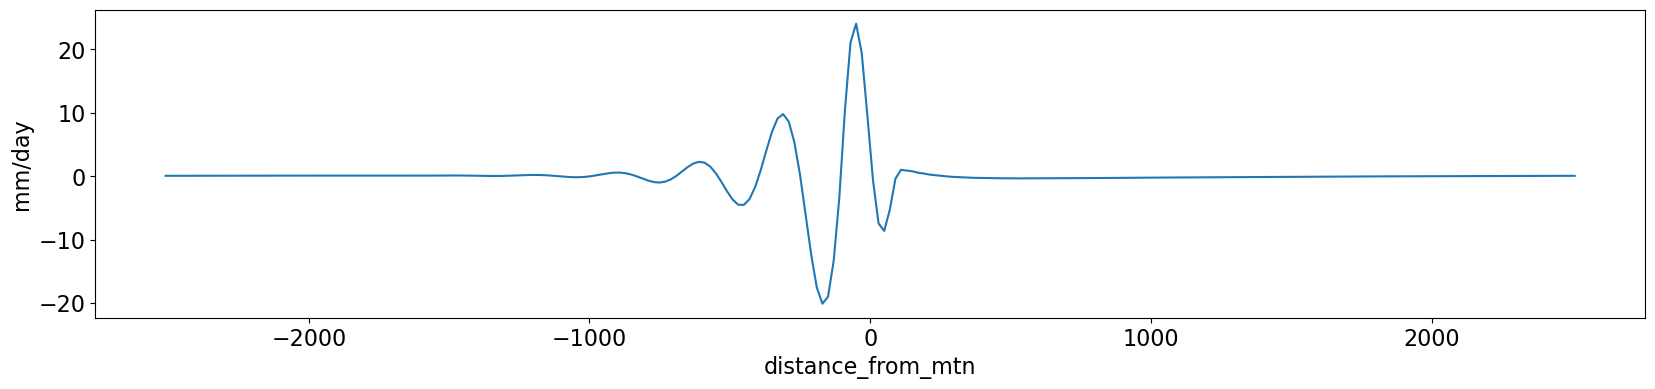

In [52]:
plt.figure(figsize=(20,4))
(-Qc__.integrate('pressure')*cp/Lv/g*100*86400).plot()
plt.ylabel('mm/day')

In [27]:
%time _,_,_,Qc_long,_ = sum_sol(start=500,stride=2,coupling='half')

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 CPU times: user 3.47 s, sys: 1.61 s, total: 5.08 s
Wall time: 2.63 s


(-2000.0, 2000.0)

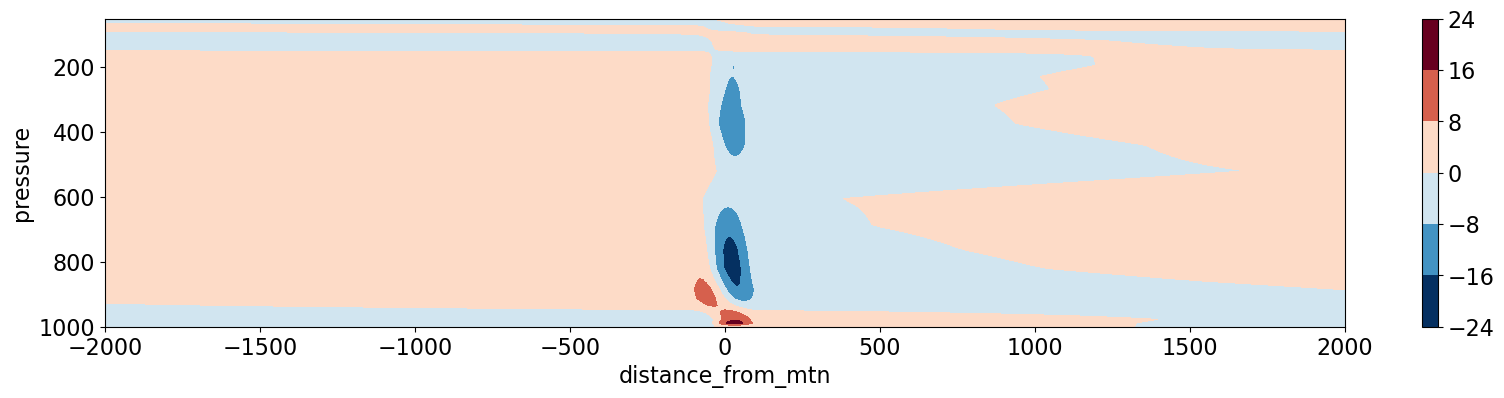

In [38]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
(86400*Qc_long).swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False)

ax.set_xlim(-2000,2000)

Text(0, 0.5, 'mm/day')

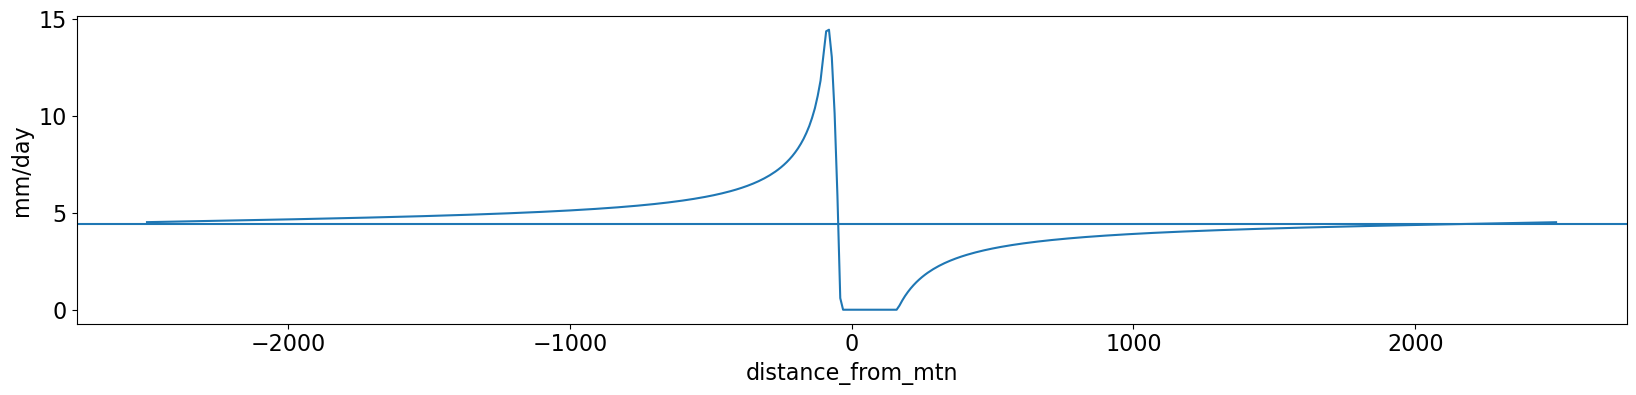

In [37]:
plt.figure(figsize=(20,4))
np.maximum(0.,4-Qc_long.integrate('pressure')*cp/Lv/g*100*86400).plot()
plt.axhline(4.4)
plt.ylabel('mm/day')

In [12]:
%time ww_long,_,_,Qc_long,_ = sum_sol(start=1000,stride=6,coupling='full')

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 CPU times: user 30.5 s, sys: 3.96 s, total: 34.5 s
Wall time: 17.3 s


(-2000.0, 2000.0)

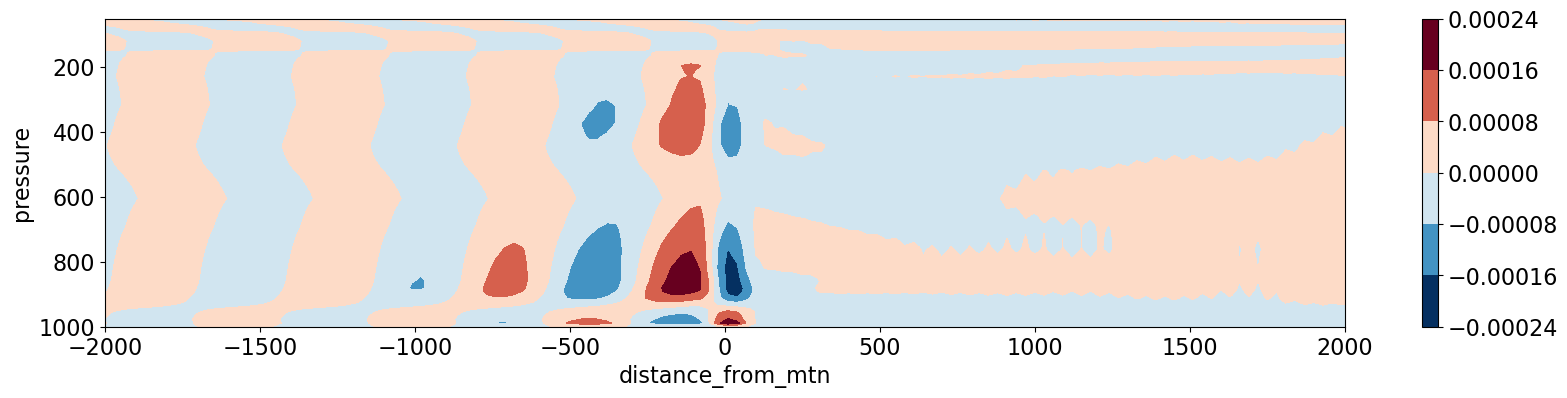

In [15]:
fig,ax = plt.subplots(1,1,figsize=(20,4))
Qc_long.swap_dims({'altitude':'pressure'}).plot.contourf(ax=ax,y='pressure',yincrease=False)

ax.set_xlim(-2000,2000)

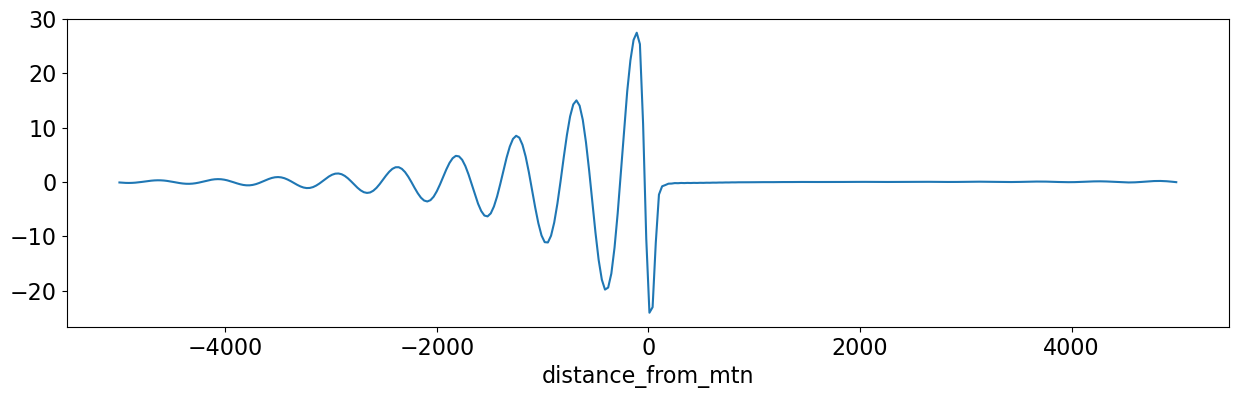

In [16]:
plt.figure(figsize=(15,4))
(-Qc_long.integrate('pressure')*cp/Lv/g*100*86400).plot()


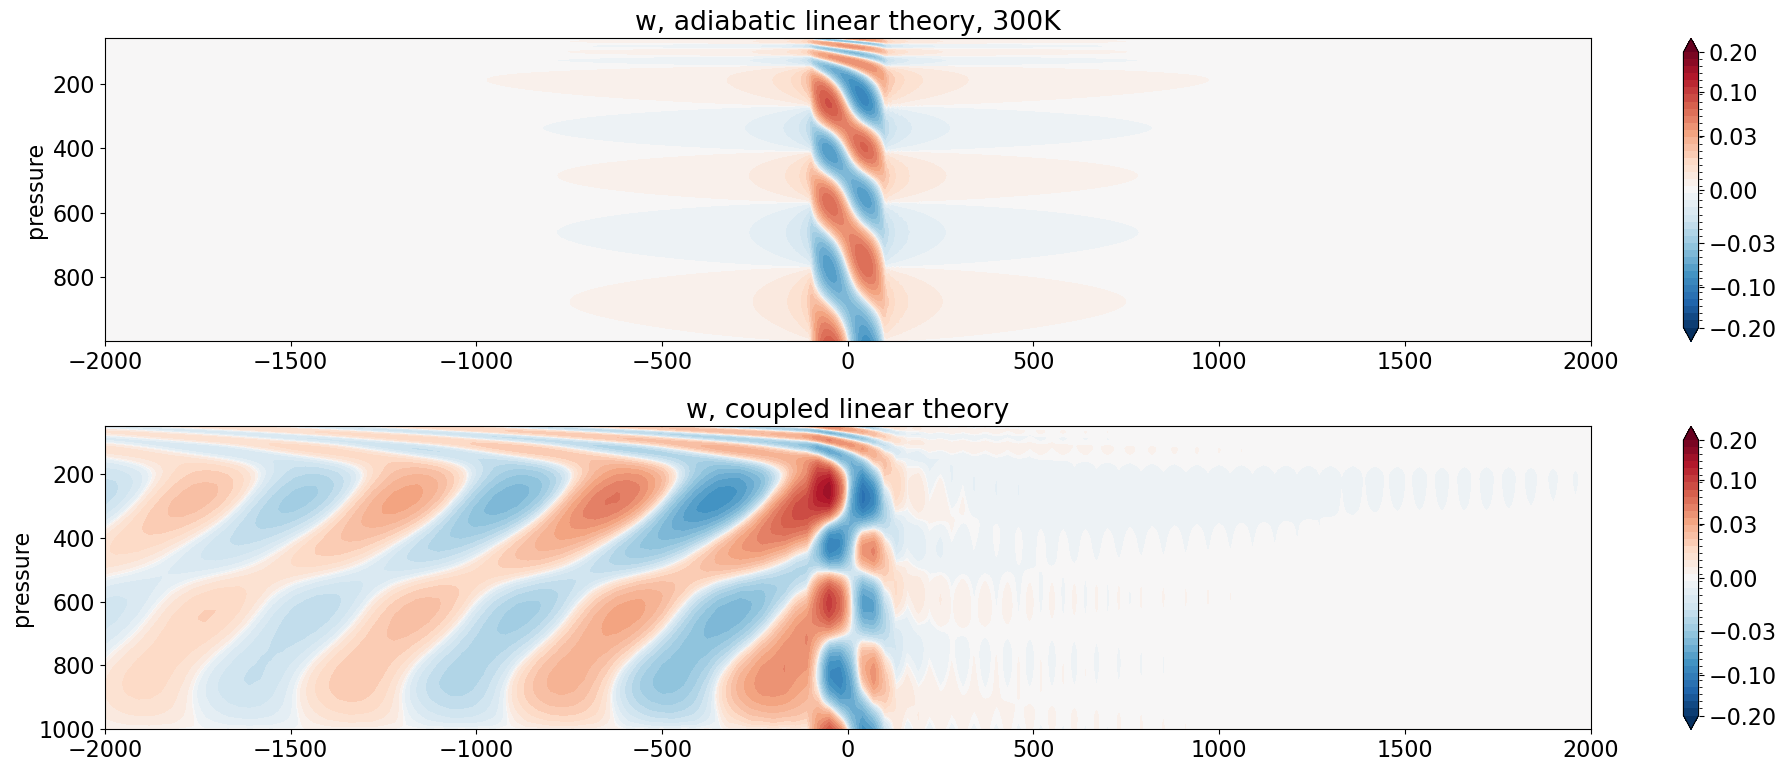

In [14]:
fig,axs = plt.subplots(2,1,figsize=(20,8))
w_300_general.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
ww_long.swap_dims({'altitude':'pressure'}).plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.set_xlabel("")
axs[0].set_title('w, adiabatic linear theory, 300K')
axs[1].set_title('w, coupled linear theory')
fig.tight_layout()

In [119]:
%time _,_,_,Qc_long_Mkuang,_ = sum_sol(start=1000,stride=6,coupling='full',MM=Mkuang)

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 CPU times: user 39.1 s, sys: 5.67 s, total: 44.7 s
Wall time: 22.5 s


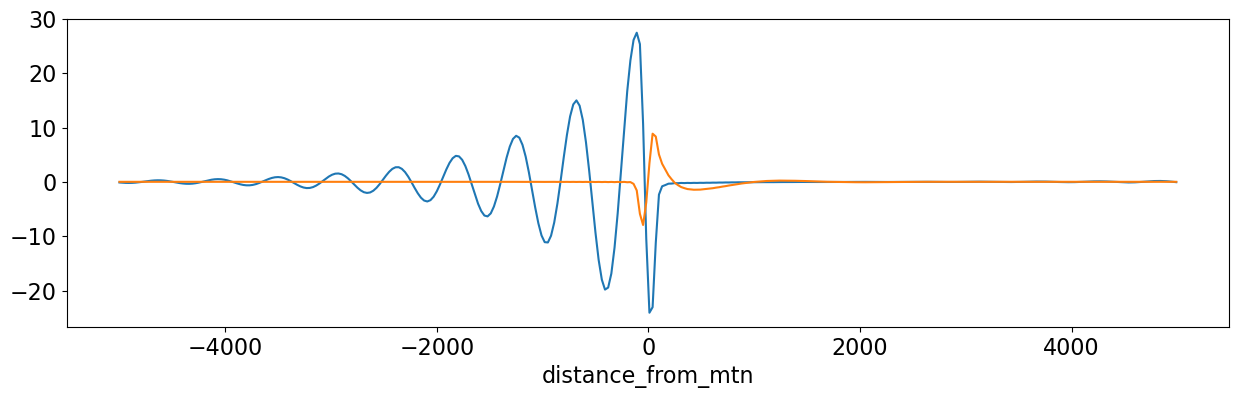

In [120]:
plt.figure(figsize=(15,4))
(-Qc_long.integrate('pressure')*cp/Lv/g*100*86400).plot()
(-Qc_long_Mkuang.integrate('pressure')*cp/Lv/g*100*86400).plot()


## Modes that blow up

In [112]:
def mode_ratios(stride=6,start=34,coupling='full'):#niter_per_mode=4
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    kk=k_vector(len(xx),xx[1]-xx[0]); kk[0] = 1e5 # just some dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    ratios  =np.zeros(len(kk))
    
    w_hat  =np.zeros((len(kk),len(zz_full)))*1j
    w_hatu  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hat  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hatu  =np.zeros((len(kk),len(zz_full)))*1j
    
    itp1_matrix = np.block([[make_interp_matrix(zz_full,zrce[:26]),np.zeros((26,len(zz_full)))],[np.zeros((14,len(zz_full))),make_interp_matrix(zz_full,zrce[:14])]])
    itp2_matrix = make_interp_matrix(zrce[:26],zz_full)
    itp3_matrix = np.block([[itp2_matrix,np.zeros((len(zz_full),14))],[np.zeros((len(zz_full),26)),make_interp_matrix(zrce[:14],zz_full)]])
    
    for i,k in enumerate(kk):
        if i%10==0:
            print(i,end=' ')
        ww,_,_,Qc,_ = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,k,h_hat[i],U0,Mkuang,coupling=coupling,itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        wwu = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k,h_hat[i],U0,0*zz_full)
        _,_,_,Qcu,_ = coupled_gw_mode(zz_full,zrce,W10S300.N2TEST_full*T0/g,W10S300.dqdz_full,k,h_hat[i],U0,Mkuang,coupling='half',itp_matrices = (itp1_matrix,itp2_matrix,itp3_matrix))  #onemode(k,h_hat[i],U0=10.,niter=niter_per_mode)
        
        
        w_hat[i] = ww
        w_hatu[i] = wwu
        Qc_hat[i] = Qc
        Qc_hatu[i] = Qcu
        
        ratios[i] = np.sum(np.abs(wwu-ww)**2)/np.sum(np.abs(wwu)**2)
        
    w_hat = xr.DataArray(w_hat,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    w_hatu = xr.DataArray(w_hatu,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qc_hat = xr.DataArray(Qc_hat,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Qc_hatu = xr.DataArray(Qc_hatu,coords={'k':kk,'altitude':zz_full/1000},dims=['k','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
      
    return kk,ratios,w_hat.sortby('k'),w_hatu.sortby('k'),Qc_hat.sortby('k'),Qc_hatu.sortby('k')


kk_,ratios_,w_hat_,w_hatu_,Qc_hat_,Qc_hatu_ = mode_ratios(start=500,stride=6,coupling='full')
 

0 

/tmp/ipykernel_26372/2794019680.py:32: RuntimeWarning: invalid value encountered in scalar divide
  ratios[i] = np.sum(np.abs(wwu-ww)**2)/np.sum(np.abs(wwu)**2)


10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 

In [85]:
xx ,hx = topographic_profile('cos',A=500)
kk_f=k_vector(len(xx),xx[1]-xx[0])
h_hat_f = np.fft.fft(hx)

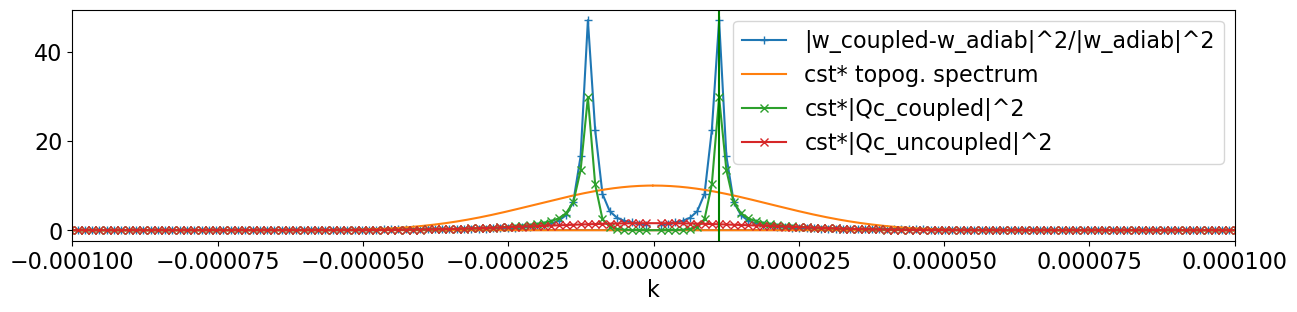

In [111]:
plt.figure(figsize=(15,3))
plt.plot(kk_,ratios_,'-+',label="|w_coupled-w_adiab|^2/|w_adiab|^2")
plt.plot(kk_f,np.abs(h_hat_f)**2/1e7,label="cst* topog. spectrum")
(10000000*np.abs(Qc_hat_)**2).mean('altitude')[:-1].plot(marker = 'x',label="cst*|Qc_coupled|^2")
(10000000*np.abs(Qc_hatu_)**2).mean('altitude')[:-1].plot(marker = 'x',label="cst*|Qc_uncoupled|^2")

plt.axvline(1.12e-5,color='g')
plt.xlim(-1e-4,1e-4)
plt.legend()

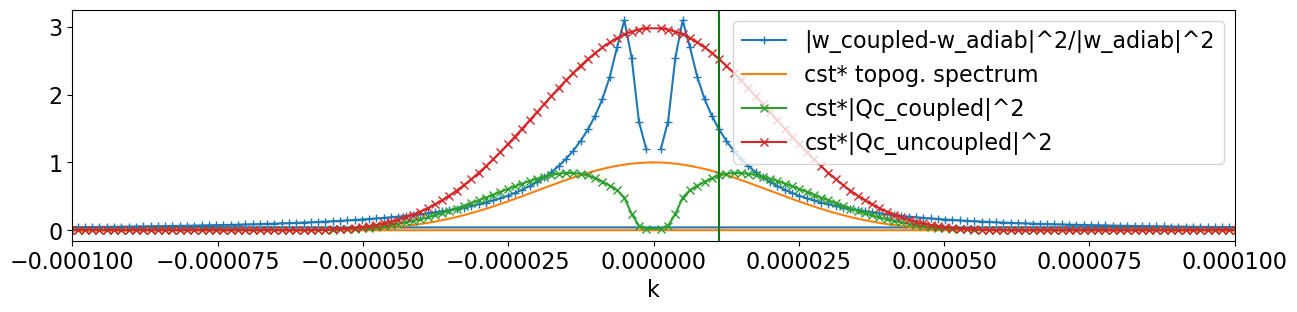

In [116]:
plt.figure(figsize=(15,3))
plt.plot(kk_,ratios_,'-+',label="|w_coupled-w_adiab|^2/|w_adiab|^2")
plt.plot(kk_f,np.abs(h_hat_f)**2/1e8,label="cst* topog. spectrum")
(30000000*np.abs(Qc_hat_)**2).mean('altitude')[:-1].plot(marker = 'x',label="cst*|Qc_coupled|^2")
(30000000*np.abs(Qc_hatu_)**2).mean('altitude')[:-1].plot(marker = 'x',label="cst*|Qc_uncoupled|^2")

plt.axvline(1.12e-5,color='g')
plt.xlim(-1e-4,1e-4)
plt.legend()

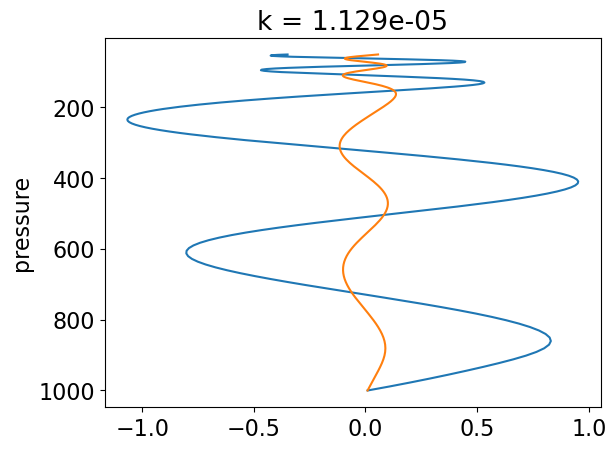

In [106]:
np.real(w_hat_.sel(k=1.12e-5,method='nearest')).plot(y='pressure',yincrease=False)
np.real(w_hatu_.sel(k=1.12e-5,method='nearest')).plot(y='pressure',yincrease=False)

## Nonlinear forcing

In [9]:
def calc_w_general_forced(start,stride,Qc,Qq):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    kk=k_vector(len(xx),xx[1]-xx[0]); kk[0] = 1e-5 # just some dummy nonzero value
    h_hat = np.fft.fft(hx); h_hat[0] = 0.
    w_hat  =np.zeros((len(kk),len(zz_full)))*1j
    T_hat  =np.zeros((len(kk),len(zz_full)))*1j
    q_hat  =np.zeros((len(kk),len(zz_full)))*1j
    Qc_hat =np.fft.fft(Qc,axis=0)
    Qq_hat =np.fft.fft(Qq,axis=0)
    
    U0=10.
    
    for i,k in enumerate(kk):
        if i%10==0:
            print(i,end=' ')
            
        #A = make_A(zz_full,W10S300.N2TEST_full/U0**2,k)
        #b = 1j*np.zeros(len(zz_full))
        #b[0] = 1j*k*U0*h_hat[i]
        ##b[1:-1] += g/T0/U0**2*Qc_hat[i][1:-1]
        #ww = np.linalg.solve(A,b)
        
        ww = gw_mode_forced(zz_full,W10S300.N2TEST_full/U0**2,k,h_hat[i],U0,Qc_hat[i]*g/(T0*U0**2))
        Tprime = (Qc_hat[i] - ww*W10S300.N2TEST_full*T0/g)/(1j*k*U0)
        qprime = (Qq_hat[i] - ww*W10S300.dqdz_full)/(1j*k*U0)
        w_hat [i] = ww
        T_hat [i] = Tprime
        q_hat [i] = qprime 
        
    ww     = xr.DataArray(np.real(np.fft.ifft(w_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    Tprime = xr.DataArray(np.real(np.fft.ifft(T_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    qprime = xr.DataArray(np.real(np.fft.ifft(q_hat ,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':zz_full/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(zz_full))})
    return ww    ,Tprime,qprime



 

In [23]:
#%time ww_long,_,_,Qc_long,Qq_long = sum_sol(start=1000,stride=6,coupling='full')
%time ww_long_nonlin,_,_          = calc_w_general_forced(1000,6,Qc_long*(Qc_long.integrate('pressure')<0),Qq_long*(Qc_long.integrate('pressure')<0))

0 10 20 30 40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 CPU times: user 1.82 s, sys: 749 ms, total: 2.57 s
Wall time: 1.3 s


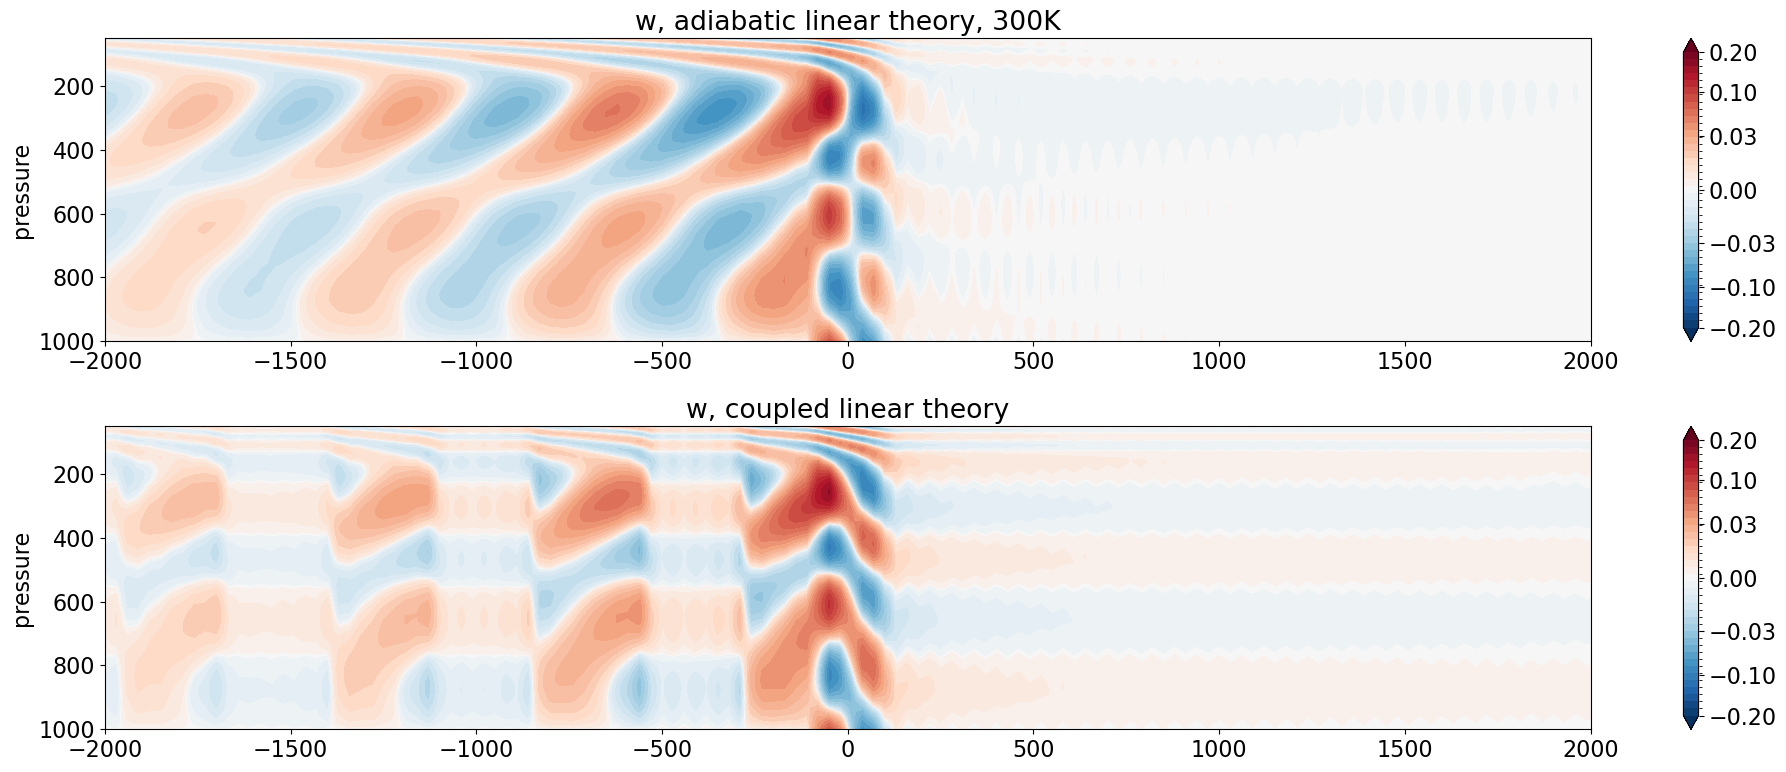

In [24]:
fig,axs = plt.subplots(2,1,figsize=(20,8))
ww_long.swap_dims({'altitude':'pressure'}).plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
ww_long_nonlin.swap_dims({'altitude':'pressure'}).plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.set_xlabel("")
axs[0].set_title('w, coupled linear theory')
axs[1].set_title('w, coupled linear theory, Qc=0 where <Qc><0')
fig.tight_layout()

(-2000.0, 2500.0)

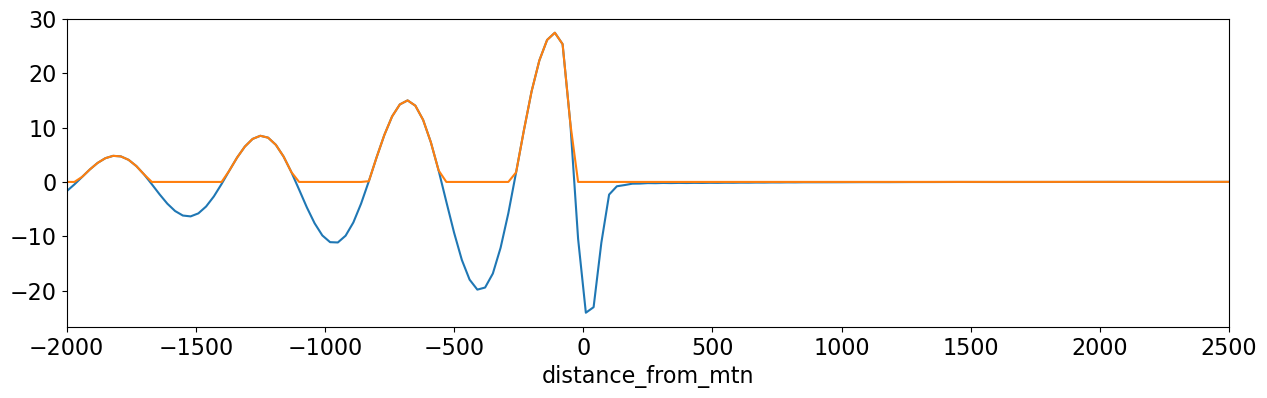

In [27]:
plt.figure(figsize=(15,4))
(-Qc_long.integrate('pressure')*cp/Lv/g*100*86400).plot()
(-Qc_long.integrate('pressure')*cp/Lv/g*100*86400*(Qc_long.integrate('pressure')<0)).plot()
plt.xlim(-2000,2500)

# Nonlinear closure

In [21]:
def get_Tqprime(ww,U,dsdz,Q):
    xx = np.array(ww.distance_from_mtn*1e3)
    kk=k_vector(len(xx),xx[1]-xx[0])
    kk=kk+1e-6*(kk==0.)
    w_hat = np.fft.fft(ww,axis=0)
    Q_hat = np.fft.fft(Q,axis=0)
    T_hat = 1/(1j*kk[:,None]*U[None,:])*(Q_hat - w_hat*dsdz[None,:])
    return np.real(np.fft.ifft(T_hat,axis=0))

def calc_w_general_forced_nonlin(Sim,stride=1,start=1000):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    z=np.arange(0,20e3,DZ)
    p = interp1d(Sim.Z_PL_SNAP,Sim.Z_PL_SNAP.pressure,kind='linear',fill_value='extrapolate')(z)
    N = interp1d(Sim.Z_PL_SNAP,Sim.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
    dqdz = interp1d(Sim.Z_PL_SNAP, np.gradient(W10S300.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP) ,kind='linear',fill_value='extrapolate')(z)
    dsdz = N**2*T0/g
    U0 = 10.
    U = U0*z**0
    
    #plt.plot(dqdz)
    #plt.plot(dsdz)
    
    ww = linear_w_generalized(xx,hx,z,U,N)
    Tprime = get_Tqprime(ww,U,dsdz,0.*ww)
    qprime = get_Tqprime(ww,U,dqdz,0.*ww)
    
    MT = make_interp_matrix(z,zrce[:26])
    Mq = make_interp_matrix(z,zrce[:14])
    MTm1 = make_interp_matrix(zrce[:26],z)
    Mqm1 = make_interp_matrix(zrce[:14],z)
    
    for i in range(3):
        print(i)
        Tq_itp = np.concatenate((np.dot(MT,Tprime.T),np.dot(Mq,qprime.T*1e3)),axis=0)
        QcQq_itp = np.dot(Mkuang2,Tq_itp)
        Qc = np.dot(MTm1,QcQq_itp[:26]).T/86400
        Qq = np.dot(Mqm1,QcQq_itp[26:]).T/(86400*1e3)
        Qc = Qc*(np.trapz(Qc,p)<0)[:,None]
        Qq = Qq*(np.trapz(Qc,p)<0)[:,None]
        # Qc = max(Qc,0)### First do without it to check previous sol
        # Qq = min(Qq,0)### First do without it to check previous sol
        ww= linear_w_generalized_forced(xx,hx,z,U,N,g*Qc/T0)###
        Tprime = get_Tqprime(ww,U,dsdz,Qc)
        qprime = get_Tqprime(ww,U,dqdz,Qq)
        
    ww = ww.assign_coords({'pressure':('altitude',p)}).swap_dims({'altitude':'pressure'})
    Tprime = ww**0*Tprime
    qprime = ww**0*qprime
    Qc = ww**0*Qc
    Qq = ww**0*Qq
    return ww,Tprime,qprime,Qc,Qq


In [22]:
ww,Tprime,qprime,Qc,Qq = calc_w_general_forced_nonlin(W10S300,stride=2,start=500)

0 500 0
0 500 1
0 500 2
0 500 

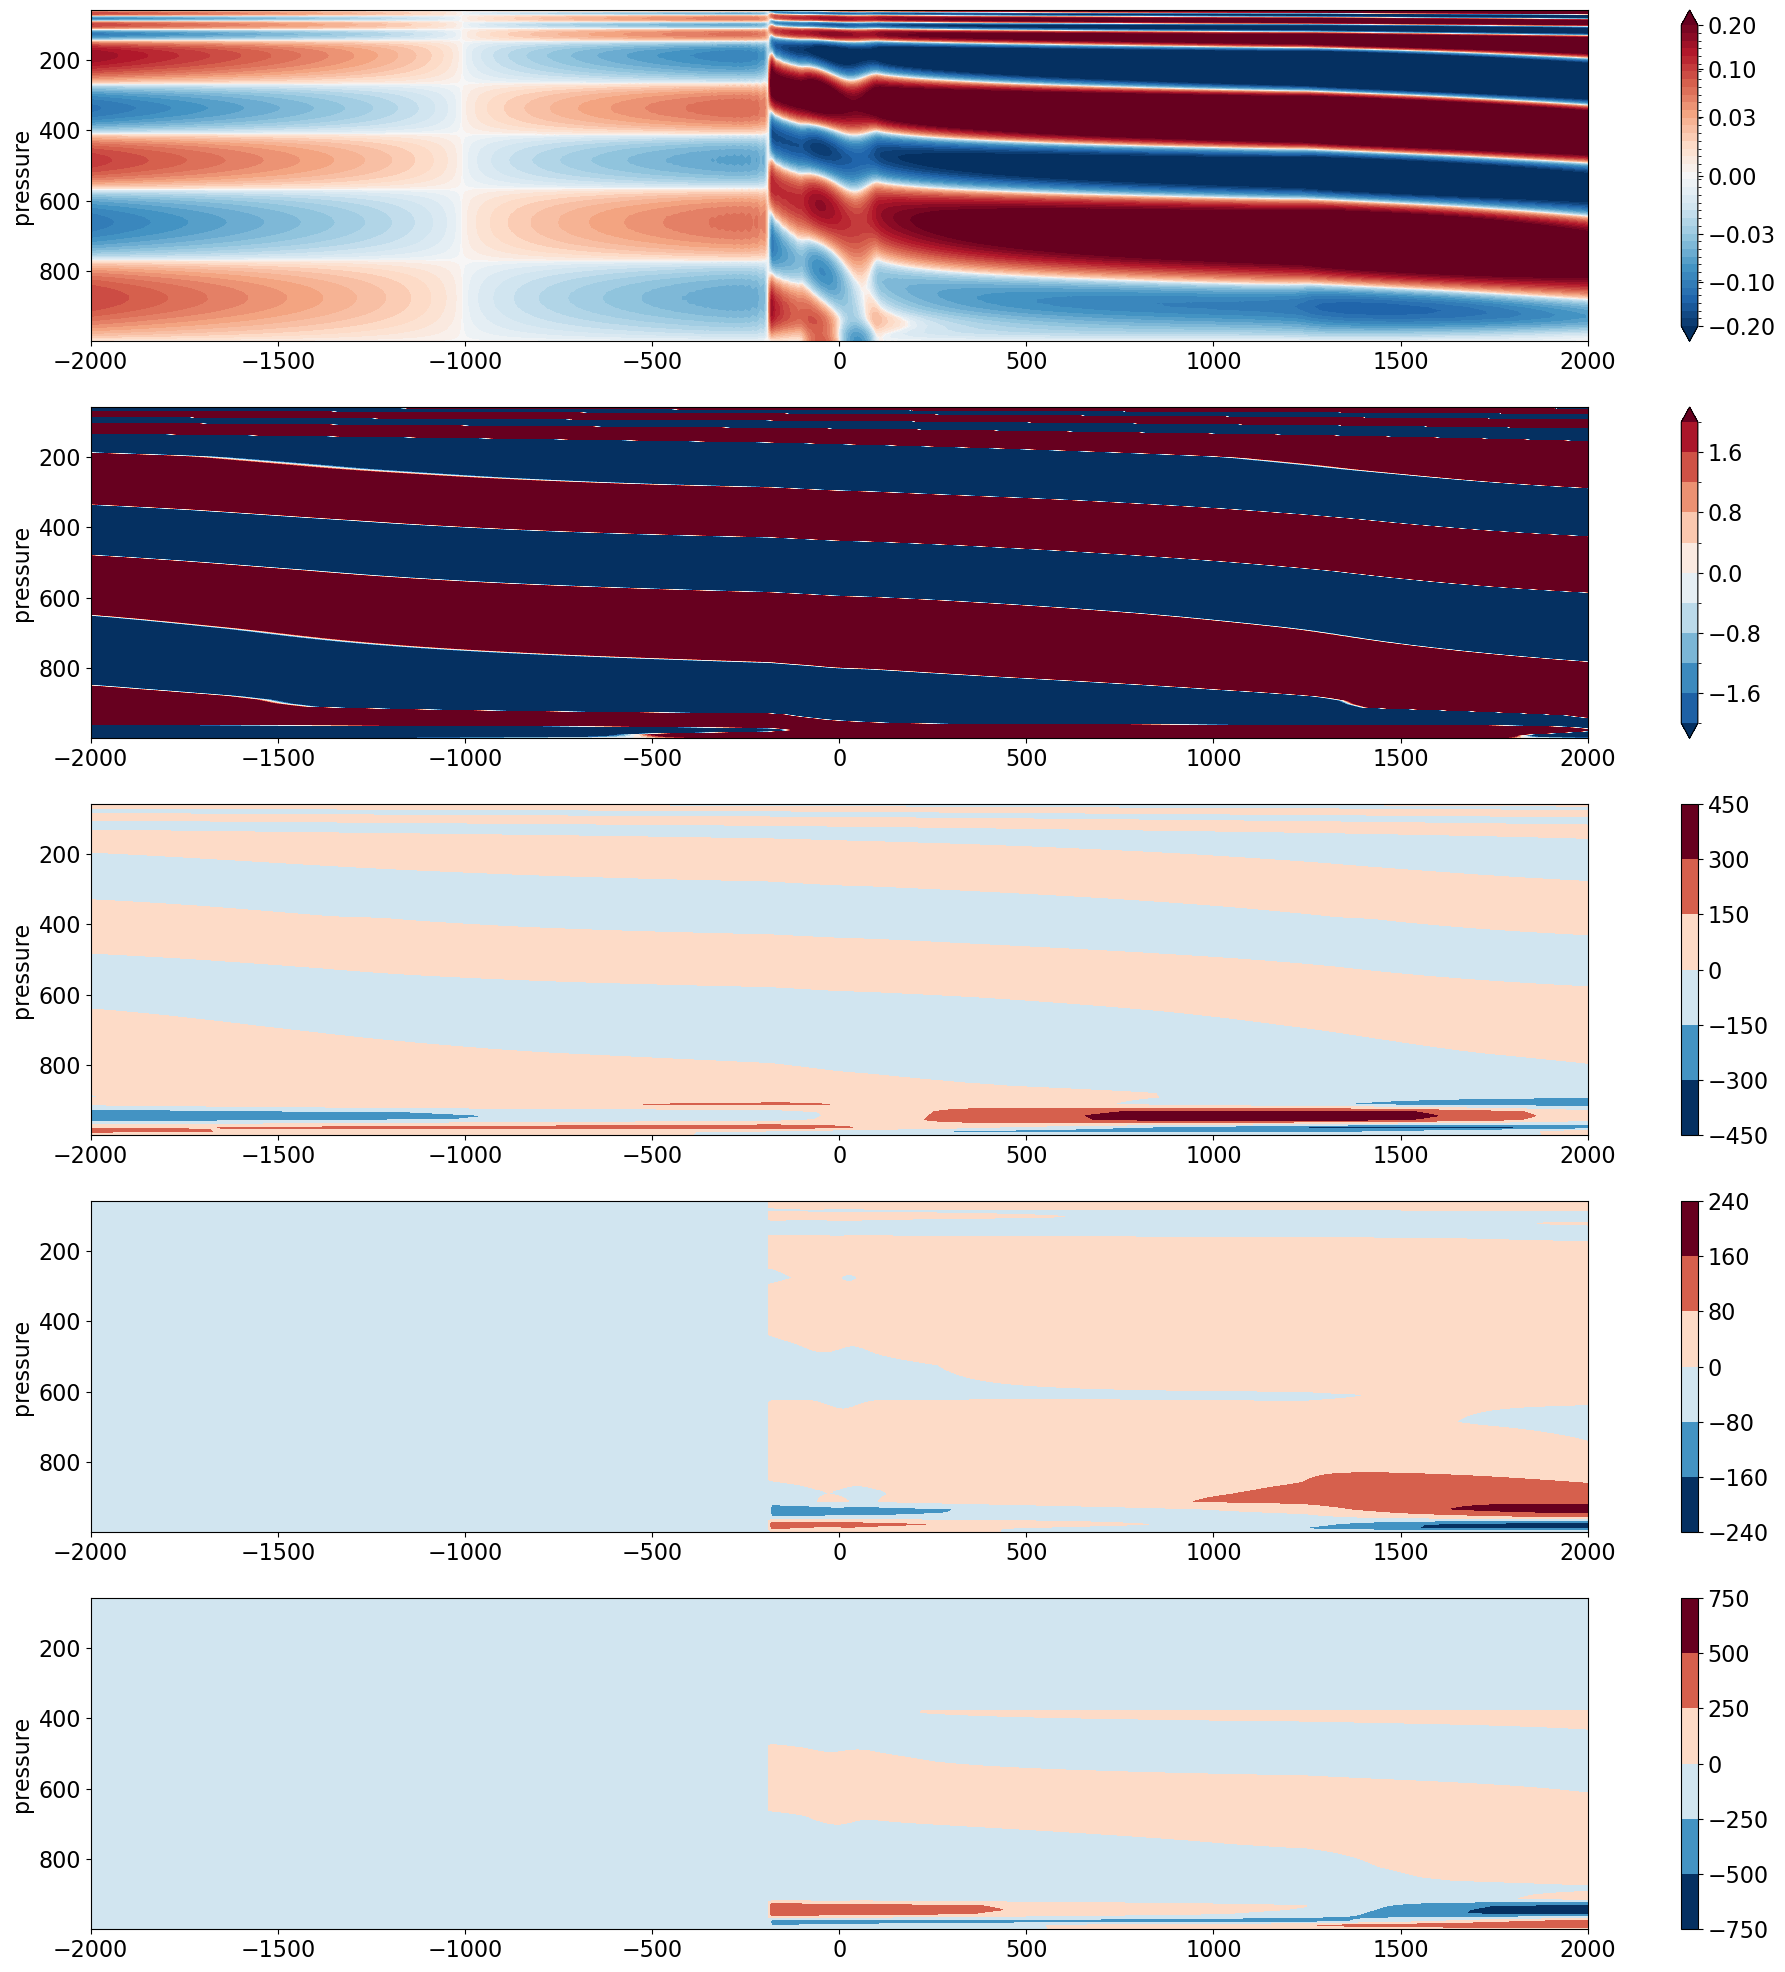

In [23]:
fig,axs = plt.subplots(5,1,figsize=(20,20))
#w_300_general#
ww.plot.contourf(ax=axs[0],y='pressure',yincrease=False,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
Tprime.plot.contourf(ax=axs[1],y='pressure',yincrease=False,levels=np.linspace(-2,2,11),extend='both')
(1e3*qprime).plot.contourf(ax=axs[2],y='pressure',yincrease=False)
(86400*Qc).plot.contourf(ax=axs[3],y='pressure',yincrease=False)
(86400e3*Qq).plot.contourf(ax=axs[4],y='pressure',yincrease=False)

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.set_xlabel("")
fig.tight_layout()

In [169]:
def linear_w_generalized_fourier(xx,hx,z,Uz,Nz,qhatz):
    "z must be evenly spaced"
    kk=k_vector(len(xx),xx[1]-xx[0])
    h_hat = np.fft.fft(hx)
    lz2 = Nz**2/Uz**2
    
    w_hat =np.zeros((len(kk),len(z)))*1j
    for i,k in enumerate(kk):
        if i%500==0:
            print(i,end=' ')
        w_hat[i] = gw_mode_forced(z,lz2,k,h_hat[i],Uz[0],qhatz[i,:]/Uz**2)
    return w_hat

def calc_w_general_fourier_nonlin(Sim,stride=1,start=1000):
    xx ,hx = topographic_profile('cos',A=500)
    xx = xx[2000-start:2000+start+1:stride]
    hx = hx[2000-start:2000+start+1:stride]
    
    kk=k_vector(len(xx),xx[1]-xx[0])
    kk=kk+1e-4*(kk==0.)
    
    z=np.arange(0,20e3,DZ)
    p = interp1d(Sim.Z_PL_SNAP,Sim.Z_PL_SNAP.pressure,kind='linear',fill_value='extrapolate')(z)
    N = 0.01*z**0
    #N = interp1d(Sim.Z_PL_SNAP,Sim.N_PL_MEAN,kind='linear',fill_value='extrapolate')(z)
    dqdz = interp1d(Sim.Z_PL_SNAP, np.gradient(W10S300.Q_PL_MEAN.sel(distance_from_mtn=slice(-2000,-5000)).mean('distance_from_mtn'),W10S300.Z_PL_SNAP) ,kind='linear',fill_value='extrapolate')(z)
    dsdz = N**2*T0/g
    U0 = 10.
    U = U0*z**0
    
    print(kk)
    
    #plt.plot(dqdz)
    #plt.plot(dsdz)
    
    ww = linear_w_generalized(xx,hx,z,U,N)
    w_hat = np.fft.fft(ww,axis=0)
    
    Tprime_hat = 1/(1j*kk[:,None]*U[None,:])*( - w_hat*dsdz[None,:])
    qprime_hat = 1/(1j*kk[:,None]*U[None,:])*( - w_hat*dqdz[None,:])
    print(Tprime_hat.shape)
    
    MT = make_interp_matrix(z,zrce[:26])
    Mq = make_interp_matrix(z,zrce[:14])
    MTm1 = make_interp_matrix(zrce[:26],z)
    Mqm1 = make_interp_matrix(zrce[:14],z)
    
    for i in range(5):
        print(i)
        Tq_itp = np.concatenate((np.dot(MT,Tprime_hat.T),np.dot(Mq,qprime_hat.T*1e3)),axis=0)
        QcQq_itp = np.dot(Mkuang2,Tq_itp)
        Qc = np.dot(MTm1,QcQq_itp[:26]).T/86400
        Qq = np.dot(Mqm1,QcQq_itp[26:]).T/(86400*1e3)
        # Qc = max(Qc,0)### First do without it to check previous sol
        # Qq = min(Qq,0)### First do without it to check previous sol
        w_hat = linear_w_generalized_fourier(xx,hx,z,U,N,g*Qc/T0)###
        Tprime_hat = 1/(1j*kk[:,None]*U[None,:])*(Qc - w_hat*dsdz[None,:])
        qprime_hat = 1/(1j*kk[:,None]*U[None,:])*(Qq - w_hat*dqdz[None,:])
    
    ww     = xr.DataArray(np.real(np.fft.ifft(w_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))}).swap_dims({'altitude':'pressure'})
    Tprime = xr.DataArray(np.real(np.fft.ifft(Tprime_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))}).swap_dims({'altitude':'pressure'})
    qprime = xr.DataArray(np.real(np.fft.ifft(qprime_hat,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))}).swap_dims({'altitude':'pressure'})
    Qc     = xr.DataArray(np.real(np.fft.ifft(Qc,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))}).swap_dims({'altitude':'pressure'})
    Qq     = xr.DataArray(np.real(np.fft.ifft(Qq,axis=0)),coords={'distance_from_mtn':xx/1000,'altitude':z/1000},dims=['distance_from_mtn','altitude']).assign_coords({'pressure':('altitude',z_to_p_standard(z))}).swap_dims({'altitude':'pressure'})
             
    return ww,Tprime,qprime,Qc,Qq


In [170]:
ww,Tprime,qprime,Qc,Qq = calc_w_general_fourier_nonlin(W10S300,stride=6,start=50)

[ 1.00000000e-04  1.23199712e-05  2.46399424e-05  3.69599136e-05
  4.92798848e-05  6.15998560e-05  7.39198271e-05  8.62397983e-05
  9.85597695e-05 -9.85597695e-05 -8.62397983e-05 -7.39198271e-05
 -6.15998560e-05 -4.92798848e-05 -3.69599136e-05 -2.46399424e-05
 -1.23199712e-05]
0 (17, 200)
0
0 1
0 2
0 3
0 4
0 

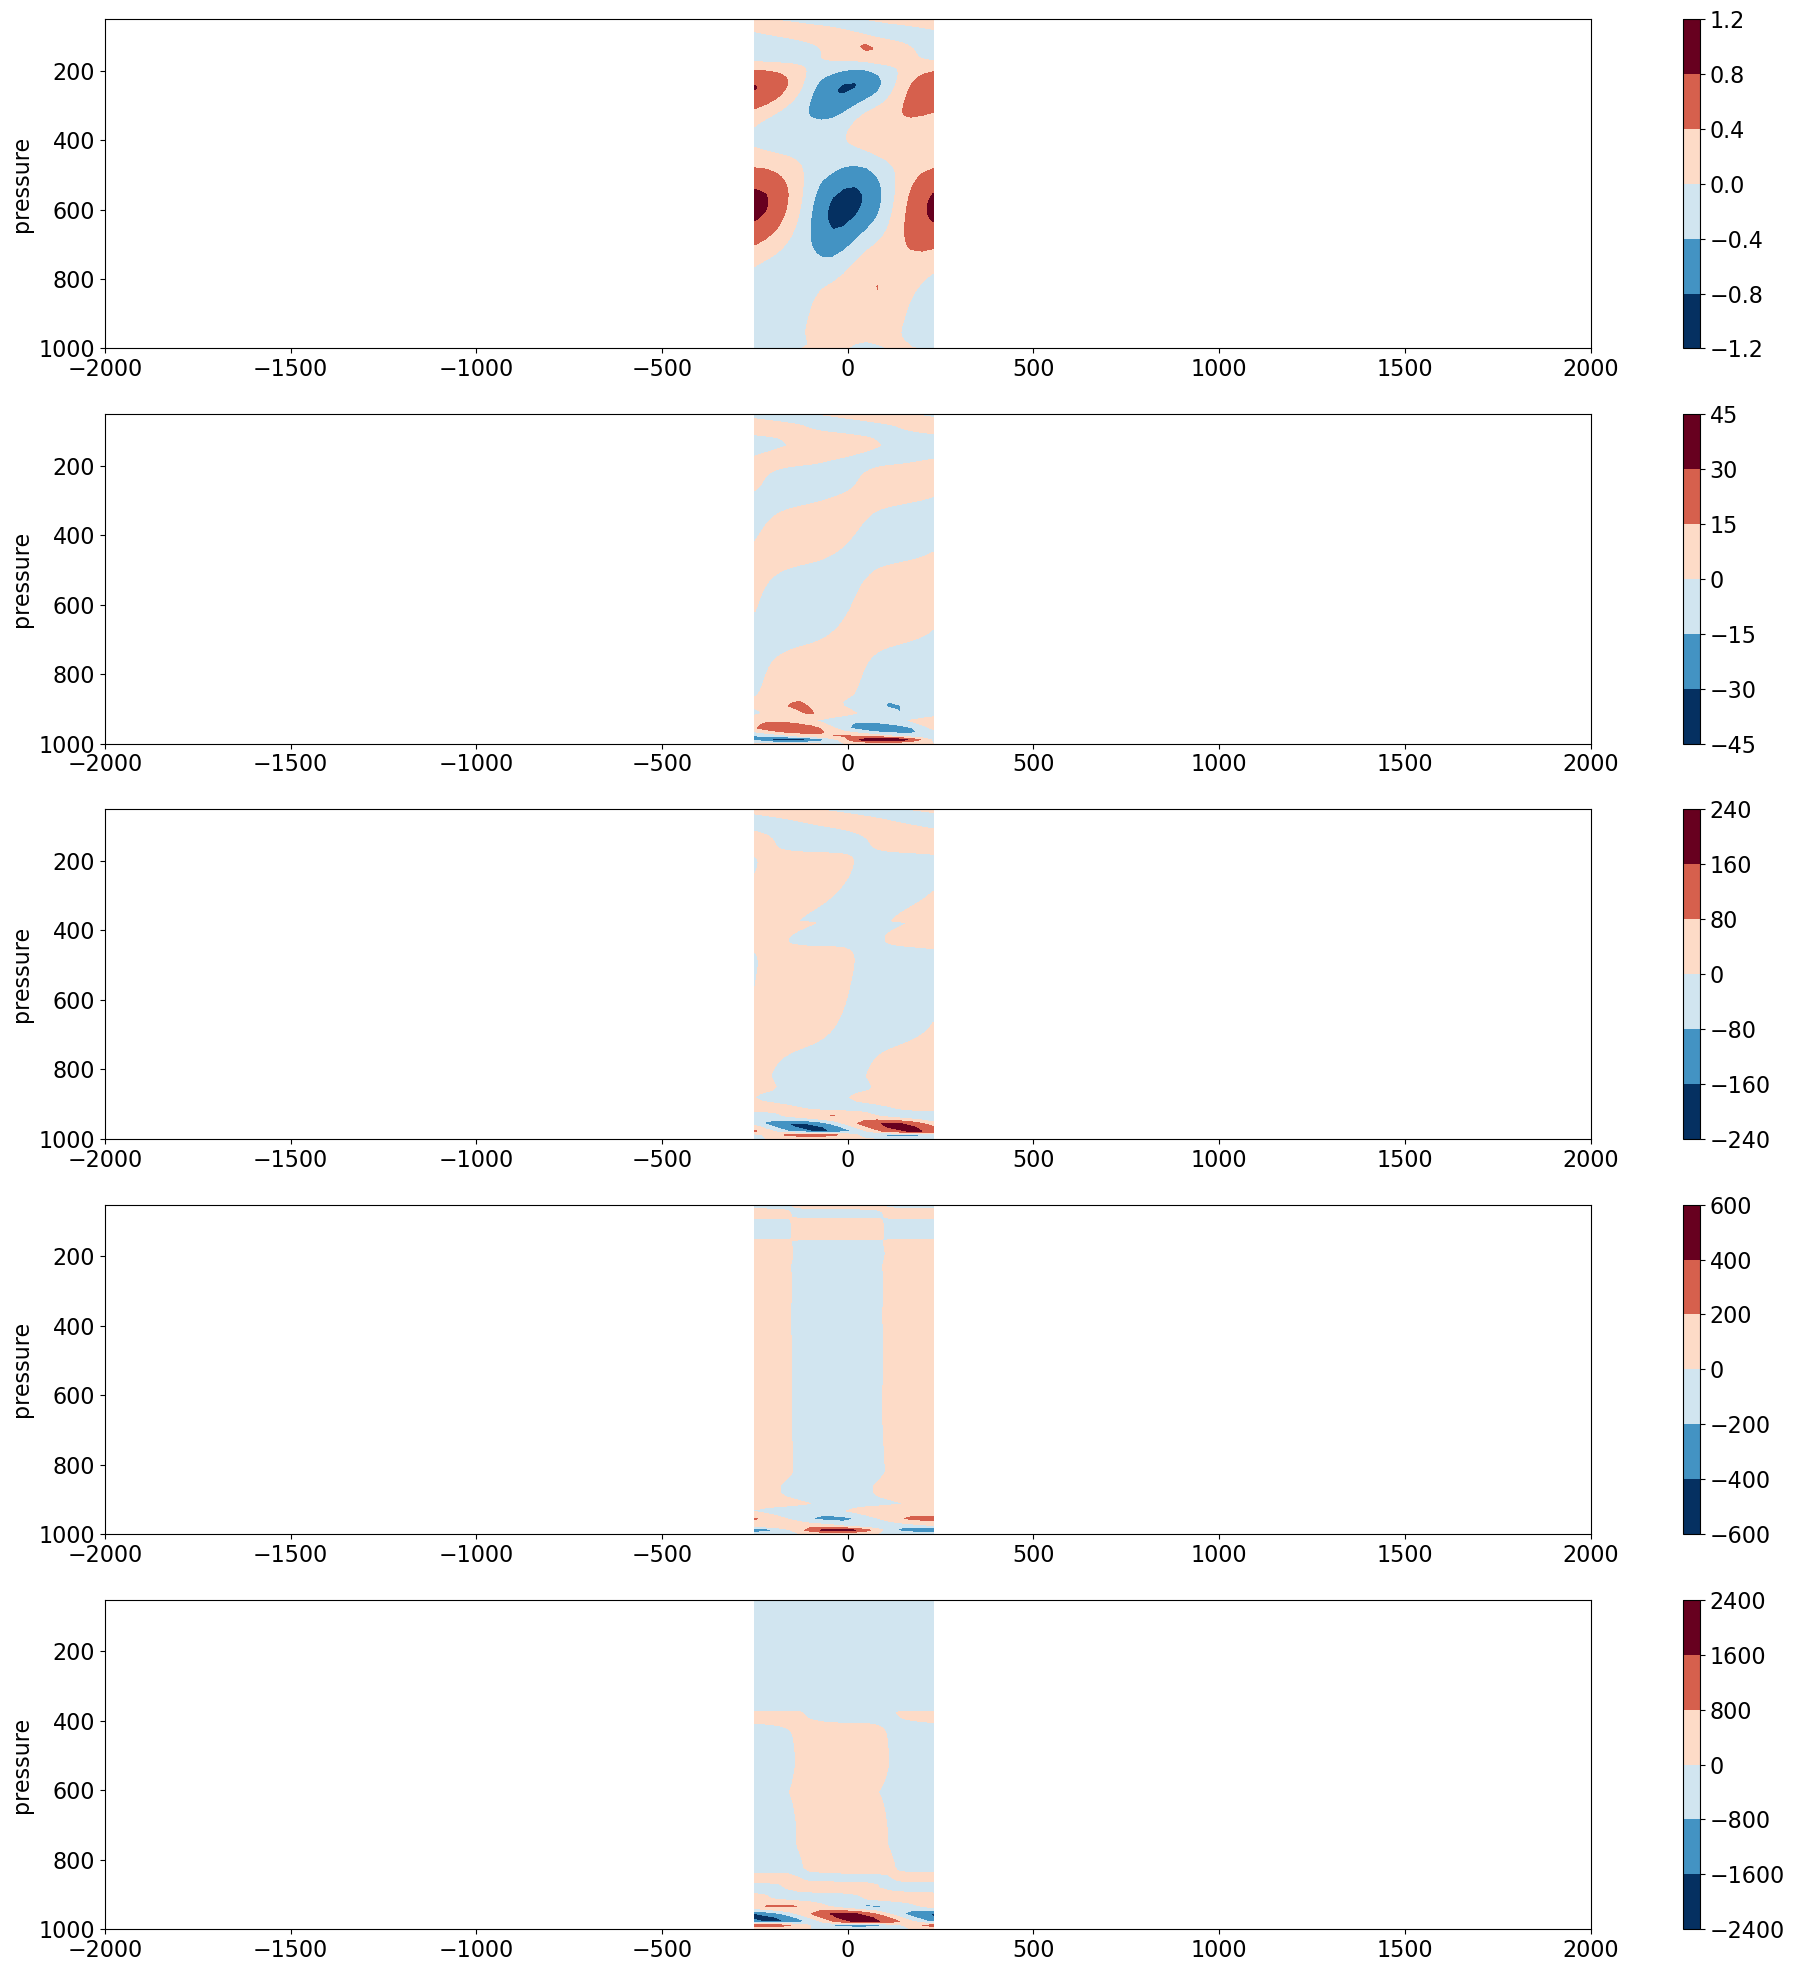

In [171]:
fig,axs = plt.subplots(5,1,figsize=(20,20))
#w_300_general#
ww.plot.contourf(ax=axs[0],y='pressure',yincrease=False)#,levels=levs1,extend='both',cbar_kwargs={'ticks':wticks})
Tprime.plot.contourf(ax=axs[1],y='pressure',yincrease=False)#,levels=np.linspace(-2,2,11),extend='both')
(1e3*qprime).plot.contourf(ax=axs[2],y='pressure',yincrease=False)
(86400*Qc).plot.contourf(ax=axs[3],y='pressure',yincrease=False)
(86400e3*Qq).plot.contourf(ax=axs[4],y='pressure',yincrease=False)

for ax in axs:
    ax.set_xlim(-2000,2000)
    ax.set_xlabel("")
fig.tight_layout()

# Two different ways of coupling

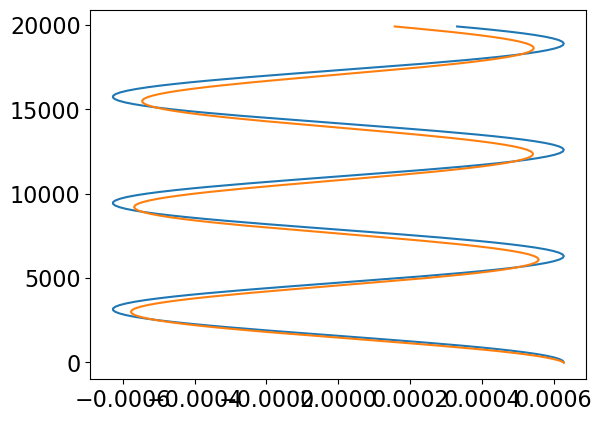

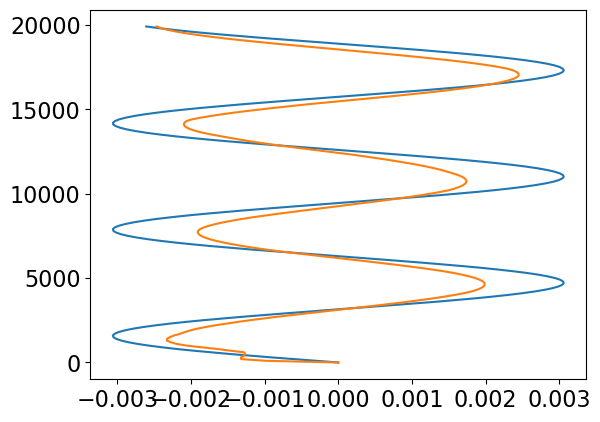

In [30]:
def first_rhsmatrix(z,zrce,ds0dz,k,U0,MM):
    dz = z[1]-z[0]
    strat_matrix = np.diag(ds0dz)
    itp1_matrix = make_interp_matrix(z,zrce[:26])
    itp2_matrix = make_interp_matrix(zrce[:26],z)
    MMitp = np.linalg.multi_dot((itp2_matrix, MM[:26,:26], itp1_matrix))/86400
    
    rhsmatrix = np.block([[-dz**2*g/(T0*1j*k*U0**3)*np.dot(strat_matrix,MMitp),dz**2*g/(T0*1j*k*U0**3)*np.dot(MMitp,MMitp)],
                          [-1/(1j*k*U0)*strat_matrix,1/(1j*k*U0)*MMitp]
                         ])
    rhsmatrix[0] = 0.
    rhsmatrix[len(z)-1] = 0.
    return rhsmatrix

def second_rhsmatrix(z,zrce,ds0dz,k,U0,MM):
    dz = z[1]-z[0]
    strat_matrix = np.diag(ds0dz)
    itp1_matrix = make_interp_matrix(z,zrce[:26])
    itp2_matrix = make_interp_matrix(zrce[:26],z)
    MMinvitp = np.linalg.multi_dot((itp2_matrix, spl.inv(MM[:26,:26]/86400), itp1_matrix))

    rhsmatrix = np.block([[-dz**2*g/T0*strat_matrix,1j*g*k/(T0*U0)*np.eye(len(z))],
                          [np.dot(MMinvitp,strat_matrix),1j*k*U0*MMinvitp]
                         ])
    rhsmatrix[0] = 0.
    rhsmatrix[len(z)-1] = 0.
    return rhsmatrix

def lhsmatrix_rhsvec(z,ds0dz,k,hhatk,U0):
    n=len(z)
    A = make_A(z,ds0dz*g/T0/U0**2,k)
    b = 1j*np.zeros(2*n)
    b[0] = 1j*k*U0*hhatk    
    return np.block([[A,np.zeros((n,n))],[np.zeros((n,n)),np.eye(n)]]),b

AA,bb = lhsmatrix_rhsvec(zz_full,0*zz_full+N0**2*T0/g,k0,hhat0,U0)
BB = first_rhsmatrix(zz_full,zrce,0*zz_full+N0**2*T0/g,k0,U0,Mkuang2)
BB2 = second_rhsmatrix(zz_full,zrce,0*zz_full+N0**2*T0/g,k0,U0,Mkuang2)

ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)
bprime = (-ww*N0**2)/(1j*k0*U0)
Tprime = bprime/g*300.
wT0 = np.concatenate((ww,Tprime))
wT = wT0

for i in range(2):
    wT = spl.solve(AA,np.dot(BB,wT)+bb)
    
plt.plot(np.imag(wT0[:len(zz_full)]),zz_full)
plt.plot(np.imag(wT[:len(zz_full)]),zz_full)
plt.figure()
plt.plot(np.imag(wT0[len(zz_full):]),zz_full)
plt.plot(np.imag(wT[len(zz_full):]),zz_full)

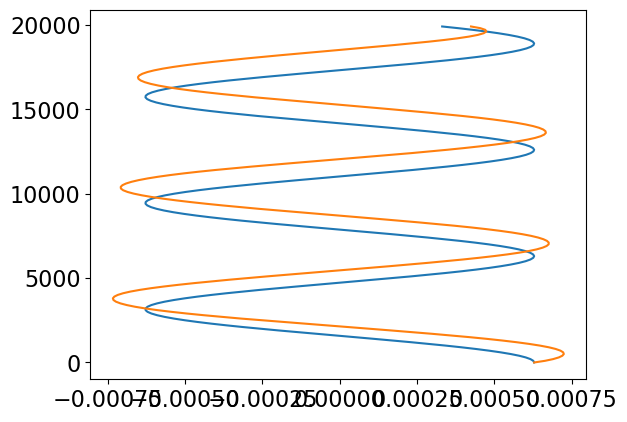

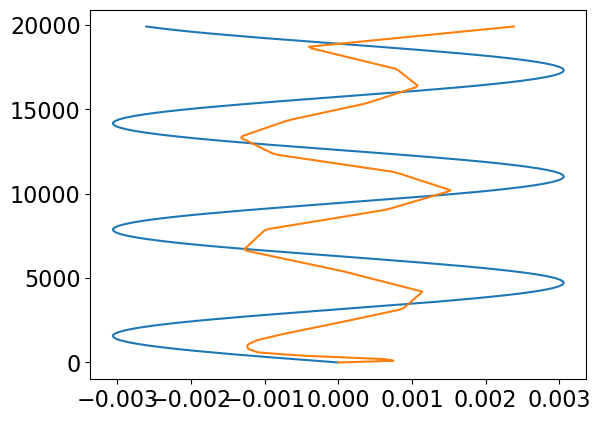

In [28]:
def first_rhsmatrix(z,zrce,ds0dz,k,U0,MM):
    dz = z[1]-z[0]
    n=len(z)
    strat_matrix = np.diag(ds0dz)
    itp1_matrix = make_interp_matrix(z,zrce[:26])
    itp2_matrix = make_interp_matrix(zrce[:26],z)
    MMitp = np.linalg.multi_dot((itp2_matrix, MM[:26,:26], itp1_matrix))/86400
    
    rhsmatrix = np.block([[np.zeros((n,n)),np.zeros((n,n)),dz**2*g/T0/U0**2*np.eye(n)],
                          [-1/(1j*k*U0)*strat_matrix,np.zeros((n,n)),1/(1j*k*U0)*np.eye(n)],
                          [np.zeros((n,n)),MMitp,np.zeros((n,n))]
                         ])

    rhsmatrix[0] = 0.
    rhsmatrix[len(z)-1] = 0.
    return rhsmatrix

def second_rhsmatrix(z,zrce,ds0dz,k,U0,MM):
    dz = z[1]-z[0]
    n=len(z)
    strat_matrix = np.diag(ds0dz)
    itp1_matrix = make_interp_matrix(z,zrce[:26])
    itp2_matrix = make_interp_matrix(zrce[:26],z)
    #MMitp = np.linalg.multi_dot((itp2_matrix, MM[:26,:26], itp1_matrix))/86400
    #MMinvitp = spl.inv(MMitp)
    MMinvitp = np.linalg.multi_dot((itp2_matrix, spl.inv(MM[:26,:26]/86400), itp1_matrix))

    rhsmatrix = np.block([[np.zeros((n,n)),np.zeros((n,n)),dz**2*g/T0/U0**2*np.eye(n)],
                          [np.zeros((n,n)),np.zeros((n,n)),MMinvitp],
                          [strat_matrix,(1j*k*U0)*np.eye(n),np.zeros((n,n))]
                         ])
    rhsmatrix[0] = 0.
    rhsmatrix[len(z)-1] = 0.
    return rhsmatrix

def lhsmatrix_rhsvec(z,ds0dz,k,hhatk,U0):
    n=len(z)
    A = make_A(z,ds0dz*g/T0/U0**2,k)
    b = 1j*np.zeros(3*n)
    b[0] = 1j*k*U0*hhatk    
    return np.block([[A,np.zeros((n,n)),np.zeros((n,n))],[np.zeros((n,n)),np.eye(n),np.zeros((n,n))],[np.zeros((n,n)),np.zeros((n,n)),np.eye(n)]]),b

AA,bb = lhsmatrix_rhsvec(zz_full,0*zz_full+N0**2*T0/g,k0,hhat0,U0)
BB = first_rhsmatrix(zz_full,zrce,0*zz_full+N0**2*T0/g,k0,U0,Mkuang2)
BB2 = second_rhsmatrix(zz_full,zrce,0*zz_full+N0**2*T0/g,k0,U0,Mkuang)

ww = gw_mode_forced(zz_full,0*zz_full+N0**2/U0**2,k0,hhat0,U0,0*zz_full)
bprime = (-ww*N0**2)/(1j*k0*U0)
Tprime = bprime/g*300.
Qprime=np.zeros(len(Tprime))
wT0 = np.concatenate((ww,Tprime,Qprime))
wT = wT0

MM = AA-BB2
NN = -BB2

for i in range(10):
#    wT = spl.solve(AA,np.dot(BB,wT)+bb)
    wT = spl.solve(MM,np.dot(BB2+NN,wT)+bb)
    
plt.plot(np.imag(wT0[:len(zz_full)]),zz_full)
plt.plot(np.imag(wT[:len(zz_full)]),zz_full)
plt.figure()
plt.plot(np.imag(wT0[len(zz_full):2*len(zz_full)]),zz_full)
plt.plot(np.imag(wT[len(zz_full):2*len(zz_full)]),zz_full)

In [24]:
list({1,2,3})

[1, 2, 3]

In [25]:
list=[3,7]

In [26]:
list({1,2,3})

TypeError: 'list' object is not callable